In [1]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib as plt
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate
import numpy as np

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [3]:
bib = bib_data.entries

### Here are the 3 datasets we will start with.

In [4]:
bib_df = pd.DataFrame.from_dict(bib) # large one from the Bibliography
review_df = pd.read_csv('no_citation_text.csv', dtype='str') # MR numbers who came back with no `GAP` text found inside
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str') # CItations scraped from MathSciNet website

# Larger dataset from Bibliography

* how to deal with NaN missing values ? *

We only need some of these columns, hence we `drop` the rest.

In [5]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

In [6]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [7]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

We reorder the columns.

In [8]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MR` so we cane later merge this dataframe with the other one.

In [9]:
bib_df.columns = ['MR', 'Author', 'Journal', 'Year', 'Publication Type']
bib_df

,MR,Author,Journal,Year,Publication Type
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
...,...,...,...,...,...
3362,2647300,"Zusmanovich, P.",J. Geom. Phys.,2010,article
3363,2735394,"Zusmanovich, P.",J. Algebra,2010,article
3364,3201064,"Zusmanovich, P.",J. Algebra,2014,article
3365,3598575,"Zusmanovich, P.",Linear Algebra Appl.,2017,article


Data types and count of non-null values for each columns.

In [10]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                3159 non-null   object
 1   Author            3367 non-null   object
 2   Journal           3047 non-null   object
 3   Year              3367 non-null   object
 4   Publication Type  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [11]:
bib_df.iloc[3274]

MR                            NaN
Author                 Wegner, A.
Journal                       NaN
Year                         1989
Publication Type    mastersthesis
Name: 3274, dtype: object

In [12]:
bib_df.describe()

,MR,Author,Journal,Year,Publication Type
count,3159,3367,3047,3367,3367
unique,3158,2511,384,43,10
top,3656296,"Eick, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` column. There are several anomalies and we need just 4 digits in each cell.

In [13]:
bib_df.sort_values('Year', ascending=False)

,MR,Author,Journal,Year,Publication Type
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [14]:
bib_df['Year'] = bib_df['Year'].str.extract(r'^(\d{4})', expand=False)

Now we convert the column Data type back to numeric.

In [15]:
bib_df['Year'] = pd.to_numeric(bib_df['Year'])

In [16]:
bib_df['Year'].value_counts()

2017.0    188
2013.0    175
2018.0    168
2020.0    166
2019.0    165
2010.0    163
2015.0    162
2016.0    158
2014.0    154
2011.0    152
2012.0    142
2007.0    142
2008.0    132
2004.0    131
2005.0    128
2009.0    124
2006.0    118
2001.0    107
2003.0    101
1999.0     84
2002.0     84
2000.0     78
1997.0     76
1998.0     58
1995.0     56
2021.0     39
1996.0     34
1994.0     28
1993.0     25
1992.0     13
1991.0      5
1988.0      2
1989.0      2
1987.0      2
1990.0      1
Name: Year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

#  Corpus and Review

What are the GAP Citation practices ???
The longer the citation is the more details it contains - measure lenght ?

To do
+ check Citations strings lenghts to isolate too short ones

+ website count citations hacing `gap.com` string to measure how many mention the website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [17]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [18]:
pd.options.display.max_colwidth = 157

In [19]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_citation(mrno):
    r = corpus_df[corpus_df['MR'] == mrno]
    return r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']

In [20]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_c(mrno):
    r = merged_df[merged_df['MR'] == mrno]
    return r

In [21]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

unknown_ver = []

def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [22]:
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

In [23]:
def website_check(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("www|\.net|http", citation, re.IGNORECASE) != None:
        print('***Provided Website***:', mrno, citation)
        return 'Yes'
    else:
        print('***Not Provided***:', mrno, citation)
        return 'No'

* First we create the version column. Then we fill its cells with the version, where provided.

In [24]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [25]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP software via ftp from samson.math.rwth-aachen.de.
No match: M. Delgado, P. A. G

No match: Cant, A., Eick, B., 2017. HallPoly – a GAP package to compute Hall polynomials. http://www.icm.tu-bs.de/~alecant/.
No match: Costantini, M., de Graaf, W., 2012. Singular Interface – a GAP package. http://www.gap-system.org.
No match: Eick, B., Horn, M., Nickel, W., 2012. Polycyclic – a GAP package. http://www.gap-system.org.
No match: Horn, M., Wagner, N., 2018. DeepThought – a GAP package. https://duskydolphin.github.io/DeepThoughtPackage/.
No match: Schönert, M. et al. GAP 4 manual. Available at http://www-history.mcs.st-and.ac.uk/gap/.
No match: F. Celler, M. F. Newman, W. Nickel and A. C. Niemeyer, An algorithm for computing quotients of prime-power order for finitely presented groups and its implementation in GAP, Research Report 127, Australian National University, Canberra, 1993.
No match: The GAP Group, GAP—Groups, Algorithms and Programming, 2005, http://www.gap-system.org.
No match: Delgado M., García-Sánchez P. A. and Morais J.: "numericalsgps": a GAP [14] package 

No match: Besche, U., Eick, B., O'Brien, E.: The SmallGroups Library. http://www-public.tu-bs.de:8080/$\sim$beick/soft/small/small.html (2002). An accepted, GAP 4 package [11]
No match: M. Schönert et al., GAP: groups, algorithms and programming. Lehrstuhl D für Mathematik, RWTH, Aachen 1992.
No match: GAP, Lehrstuhl D für Mathematik RWTH Aachen, Version 3, Release 4, July 1994.
No match: Schönert, M. et al.: GAP: Groups, Algorithms and Programming. Lehrstuhl D für Mathematik, Aachen, 1994
No match: A. Dooms, E. Jespers, A. Konovalov and H. Verril. Congruence—Congruence subgroups of $SL_{2}(\Bbb{Z})$, GAP package, in development.
No match: W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://www.science.unitn.it/$\sim$degraaf/sla.html, 2009.
No match: W. A. De Graaf, SLA-computing with Simple Lie algebras. A GAP package (2009), http://www.science.unitn.it/~degraaf/sla.html.
No match: W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://ww

No match: J. Michel, Homepage of the development version of the GAP part of CHEVIE, see http://www.institut.math.jussieu.fr/$\sim$jmichel/chevie/chevie.html.
No match: T. Breuer, The GAP character table library. http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib/index.html
No match: J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015), pp. 308–336. 
MR3343221
No match: M. Geck, ChevLie — constructing Lie algebras and Chevalley groups in GAP, available at http://www.math.rwth-aachen.de/~CHEVIE/contrib.html, July 2016.
No match: J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015) 308–336, Webpage at https://webusers.imj-prg.fr/~jean.michel/chevie/chevie.html. 
MR3343221
No match: Computer program GAP, available from http://www-gap.dcs.st-andrews.ac.uk/$\sim$gap/
No match: S. P. Glasby, Supporting $\ssf{GAP}$ and Magma code, http://www.maths.uwa.edu.au/~glasby/RESEARCH.
No match: M. SCHO NERT et al., `GAP: groups, a

No match: M. Schönert et al., GAP: Groups, algorithms, and programming, 5th ed., Lehrstuhl D für Mathematik, RWTH Aachen, 1996. See http://www.math.rwth-aachen.de/$\sim$GAP/WWW/.
No match: The GAP Group, GAP—Groups, Algorithms, and Programming, http://www.gap-system.org.
No match: G. P. Nagy and P. Vojtěchovský, LOOPS: A package for GAP 4, http://www.math.du.edu/loops.
No match: Schönert, M.; et al. GAP-Groups, Algorithms and Programming, Lebrstuhl D für Mathematik; RWTH: Aachen, 1995.
No match: M. Schönert et al., GAP-Group, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH (Aachen, 1993).
No match: U. Jezernik and P. Moravec. "GAP Code for Computing Bogomolov Multipliers of Finite Solvable Groups." Available online (http://www.fmf.uni-lj.si/$\sim$moravec/Papers/computing-bog.g), 2014. 
MR3314282
No match: The GAP Group, `GAP–groups, algorithms, and programming', http://www.gap-system.org.
No match: J.-G. Dumas, F. Heckenbach, B. D. Saunders, and V. Welker, Simplicial Homol

No match: Eick, B. and Nickel, W.: Polycylic - A GAP [7] package, 2000 (http://www.mathematik.uni-kassel.de/$\sim$eick). 
MR2065131
No match: J. Michel, The development version of the CHEVIE package of GAP3, Journal of Algebra 435 (2015), 308–336. 
MR3343221
No match: Frank Lübeck. GAP Package EDIM. Available from World Wide Web (http://www.math.rwth-aachen. de:8001/$\sim$Frank.Luebeck/EDIM), 2004.
No match: Jürgen Müller. GAP Package IntegralMeatAxe. Unpublished, 2004.
No match: M. Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D fur Mathematik, RWTH, Aachen, 1994.
No match: M. Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D fur Mathematik, RWTH, Aachen, 1994.
No match: GAP-Groups, Algorithms and Programming (http://www.gap-system.org).
No match: GAP—Groups, Algorithms and Programming (http://www.gap-system.org).
No match: Bächle, A., Margolis, L., 2018. HeLP: a GAP package for torsion units in integral group rings. J. Softw. Algebra Geom. 8,

No match: H. Pahlings, cliffordmatrices.g, deposited contribution for GAP 4, http://www.gap-system.org/Packages/Contrib/contrib.html, 2007.
No match: The GAP Group, GAP–Groups, algorithms, and programming, http://www.gap-system.org.
No match: Thomas Breuer, The GAP Group, private communication.
No match: G. Gamble, A. Hulpke, G. Havas, C. Ramsay, M. Horn, GAP Package ACE, http://gap-packages.github.io/ace/, 1998.
No match: M. Schönert, et al., GAP—Groups, Algorithms and Programming, fourth ed., RWTH Aachen: Lehrstuhl D für Mathematik, 1994.
No match: G. Pfeiffer, Character tables of Weyl groups in GAP, Bayreuther Math. Schr. 47 (1994), 165–222. 
MR1285208
No match: J.-G. Dumas, F. Heckenbach, B. D. Saunders and V. Welker, GAP Homology, http://www.eecis.udel.edu/dumas/Homology (2011).
No match: Peter Webb, Tutorial on the gap package `reps' for handling group representations in positive characteristic, http://www-users.math.umn.edu/~webb/GAPfiles/reptutorial.html, 2016.
No match: GAP, G

No match: M. Schönert et al., "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth ed., 1995.
No match: M. Schönert et al., GAP – Groups, Algorithms, and Programming – version 3 release 4 patchlevel 4, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1997.
No match: M. Schönert et al., "GAP—Groups, Algorithms and Programming," RWTH, Aachen, 1995.
No match: M. Schönert, et al., GAP—Groups, Algorithms, and Programming, 4th Edition, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1994.
No match: The GAP Group: GAP—groups, algorithms, and programming (2012). http://www.gap-system.org/
No match: H. U. BESCHE, B. EICK, and E. O'BRIEN, The SmallGroups Library—A GAP package, GAP Group, 2016, http://www.gap-system.org/Packages/sgl.html. (381,417)
No match: GAP: Groups, algorithms, and programming (http://www/gap-system.org).


In [26]:
corpus_df['Version'].value_counts()

4.4       460
4.4.12    310
4.3       232
4.4.10    136
4.2       127
         ... 
1.7         1
0.6.6       1
0.971       1
2.8         1
1.6.1       1
Name: Version, Length: 196, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software. In entries citing GAP package there is no version of GAP provided hence we will fill the `Version` cell with `Package`.

In [27]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

***Not a Package***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Package***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Not a Package***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Not a Package***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Not a Package***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not a Package***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Not a Package***: MR2287843 The G

***Not a Package***: MR4153328 The GAP Group: The GAP Group—Groups, Algorithms, and Programming, Version 4.10.2 (2019). http://www.gap-system.org
***Not a Package***: MR4090499 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.7.9 (2015). http://www.gapsystem.org
***Not a Package***: MR4158512 The GAP group, GAP — Groups, Algorithms, and Programming, Version 4.10.2, 2019, available at https://www.gap-system.org
***Not a Package***: MR4163372 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.7.9 (2015). http://www.gap-system.org
***Not a Package***: MR4197103 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.11.0, 2020, https://www.gap-system.org.
***Not a Package***: MR2156685 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4; 2004, (http://www.gap-system.org).
***Package***: MR2501429 Delgado, M., Linton, S. and Morais, J. (2007) Automata: A GAP package (1.10). http://cmup.fc.up.pt/cmup/mdelgado/automata/
***Not

***Package***: MR2652482 R.A. Wilson, R.A. Parker, S.J. Nickerson, J.N. Bray, T. Breuer, AtlasRep, A GAP Interface to the Atlas of Group Representations, Version 1.4 2008, Refereed GAP package, http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/atlasrep.
***Not a Package***: MR2389459 Martin Schönert et al. "GAP - Groups, Algorithms, and Programming - version 3 release 4 patchlevel 4". Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1997.
***Not a Package***: MR2786171 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www. gap-system.org
***Package***: MR2786171 Graña M., Vendramin L.: RiG, A GAP package for racks and Nichols Algebras, available at http://mate. dm.uba.ar/$\sim$lvendram
***Not a Package***: MR2840161 T. Breuer, The GAP Character Table Library, Version 1.2 (unpublished); http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/
***Not a Package***: MR2840161 W. Fulton and J. Harris, Represen

***Not a Package***: MR2173965 G. Havas, M.F. Newman, E.A. O'Brien, ANU $p$-Quotient Program (version 1.4); written in C, available as a share library with GAP and as part of Magma, or from http://wwwmaths.anu.edu.au/services/ftp.html, School of Mathematical Sciences, Australian National University, Canberra, 1997.
***Not a Package***: MR2726572 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org.
***Not a Package***: MR3320863 GAP: groups, algorithms, and programming, Version 4.4.12, The GAP Group, 2008, available at http://www.gap-system.org.
***Not a Package***: MR4125845 F. Effenberger and J. Spreer, simpcomp–GAP toolkit for simplicial complexes, version 1.3.3, (2010), https://simpcomp-team.github.io/simpcomp/.
***Not a Package***: MR4125845 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.4, (2016), http://www.gap-system.org.
***Not a Package***: MR3921334 The GAP group: GAP - Groups, Algorithms, and Programm

***Not a Package***: MR2320997 GAP—Groups, Algorithms, and Programming, version 4.4, The GAP Group, 2005, http://www.gap-system.org.
***Not a Package***: MR2595090 The GAP Group, GAP - Groups, Algorithms, and Programming. Version 4.4.10, 2007. http://www.gap-system.org
***Not a Package***: MR3084710 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2008. http://www.gap-system.org.
***Not a Package***: MR3305041 The GAP Group. "GAP—Groups, Algorithms, and Programming," Version 4.4.10. Available at http://www.gap-system.org, 2008.
***Not a Package***: MR3746628 The GAP Group, "GAP —Groups, Algorithms, and Programming, Version 4.5", 2016, http://www.gap-system.org.
***Not a Package***: MR3641831 The GAP Group, GAP –Groups, Algorithms, and Programming. Version 4.4.10, 2008. http://www.gap-system.org
***Package***: MR3840333 Bartholdi, L.: FR-GAP package "Computations with functionally recursive groups", Version 2.4.3 http://www.gap-system.org/Packages/fr.html (2017)
*

***Not a Package***: MR3592325 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4 (2005), http://www.gap-system.org
***Not a Package***: MR4020334 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005, available at http://www.gap-system.org
***Not a Package***: MR3635125 The GAP Group: GAP – Groups, Algorithms and Programming, Version 4.8.3 (2016), http://www.gap-system.org.
***Package***: MR1840383 Aichinger, E., Binder, F., Ecker, J., Eggetsberger, R., Mayr, P., Nöbauer, C. (2000). SONATA: Systems of Nearrings and Their Applications, Package for the group theory system GAP4, Austria, Universität Linz. Available at http://www.algebra.uni-linz.ac.at/sonata/.
***Package***: MR2996872 Pfeiffer, G., 2007. ZigZag—A GAP3 Package for Descent Algebras of Finite Coxeter Groups. Electronically available at: http://schmidt.nuigalway.ie/zigzag.
***Not a Package***: MR2996872 Schönert, M., et al., 1997. GAP–Groups, Algorithms, and Programming–version 3 release 

***Not a Package***: MR2646433 The GAP Group, GAP-groups, algorithms and programming, version 4.4; Aachen, St Andrews, 2006 (http://www.gap-system.org).
***Package***: MR2646433 L. H. Soicher, The DESIGN package for GAP, Version 1.3, 2006, http://designtheory.org/software/gap\_design/.
***Package***: MR2646433 L. H. Soicher, The GRAPE package for GAP, Version 4.3, 2006, http://www.maths.qmul.ac.uk/$\sim$leonard/grape/.
***Not a Package***: MR2604639 The Group GAP, GAP—groups, algorithms, and programming, version 4.4, Aachen, St. Andrews, 2006, http://www.gap-system.org.
***Package***: MR2604639 L. H. Soicher, The package DESIGN for GAP, Version 1.3, 2006, http://designtheory.org/software/gap\_design/.
***Not a Package***: MR2753302 The GAP Group, GAP - groups, algorithms, and programming, version 4.4; Aachen, St. Andrews, 2006, http://www.gap-system.org.
***Package***: MR2753302 L. H. Soicher, The DESIGN package for GAP, Version 1.3, 2006, http:// designtheory.org/software/gap\_design/

***Not a Package***: MR3557650 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.8.3 (2016). http://www.gap-system.org
***Not a Package***: MR3355546 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.12, 2008 http://www.gap-system.org.
***Not a Package***: MR2555951 GAP. Groups, algorithms, programming - a system for computational discrete algebra, at http://www.gap-system.org/.
***Not a Package***: MR2831973 The Gap Group. GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org.
***Not a Package***: MR3578995 The GAP Group.: GAP—groups, algorithms, and programming, Version 4.5.6 (2013). http://www.gap-system.org
***Package***: MR3578995 Rahm, A.D., Sánchez-García, R.J.: GAP implementation of the Davis complex (2015). http://www.gap-system.org/Packages/hap.html
***Not a Package***: MR2537674 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2006.
***Not a Package***: 

***Not a Package***: MR4089566 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.2, https://www.gap-system.org, 2019.
***Not a Package***: MR1962794 Schönert, M., et al. 1995. GAP—Group, Algorithms and Programming, Lehrstuhl D fur̈ Mathematik, RWTH, Aachen.
***Not a Package***: MR2168723 Eick, B., 1993. Spezielle PAG-systeme im Computeralgebrasystem GAP. Diplomarbeit, RWTH Aachen.
***Not a Package***: MR2168723 The Gap Group, 2000. GAP—Groups, Algorithms and Programming, 4th edition. www.gap-system.org.
***Package***: MR2168723 Holt, D.F., Leedham-Green, C.R., O'Brien, E.A., Rees, S., 1996. Smash, matrix groups and $G$-Modules, A GAP share package.
***Not a Package***: MR2455702 The GAP Group. "GAP: Groups, Algorithms, and Programming, Version 4.4." Available online (http://www.gap-system.org), 2004.
***Package***: MR3551894 T. Breuer, CTblLib, - GAP's Character Table Library package, version 1.2.1 (2012), http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***N

***Package***: MR2862197 Serena Cicalò, Willem A. de Graaf, LieRing. A GAP package, http://science.unitn.it/$\sim$degraaf/liering.html, 2011.
***Not a Package***: MR2862197 The GAP Group, GAP - groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2004.
***Not a Package***: MR1822856 M. Schönert et al., GAP: Groups, algorithms, and programming, 4th ed., Lehr-stuhl D für Mathematik, RWTH Aachen, 1994. See http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR4116648 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.2; 2019, https://www.gap-system.org.
***Not a Package***: MR3911640 GAP - Groups, Algorithms, Programming - a System for Computational Discrete Algebra, Available online at http://www.gap-system.org/.
***Package***: MR3483156 M. Delgado, P. A. García-Sánchez, and J. Morais, "NumericalSgps", a GAP package for numerical semigroups; available online from http://www.gap-system.org/. 
MR3493240
***Package***: MR4152353 Delgad

***Not a Package***: MR2298755 The GAP Group. GAP — Groups, Algorithms, and Programming, Version 4, 4. http://www.gap-system.org, 2006.
***Not a Package***: MR3814569 GAP – Groups, Algorithms, and Programming, Version 4.8.7, 2017, http://www.gap-system.org/.
***Not a Package***: MR2872918 The GAP Group, GAP—groups, algorithms, and programming, version 4.4.9, 2006. http://www.gap-system.org.
***Not a Package***: MR2946468 The GAP Group: GAP—Groups, Algorithms, and Programming, version 4.4.9 (2006). http://www.gap-system.org
***Not a Package***: MR3208082 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.
***Not a Package***: MR1837963 Schönert M. et al. GAP–Groups, algorithms and programming. Version 3.4.4. Lehrstuhl D für Mathematik, RWTH Aachen, and School of Mathematical and Computational Sciences, University of St Andrews, 1997.
***Not a Package***: MR2322775 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4; 

***Not a Package***: MR2287275 The GAP Group - GAP - Groups, Algorithms, and Programming, Version 4.4, 2004. (http://www.gap-system.org).
***Package***: MR1832319 Linton, S., G. Pfeiffer, E. Robertson, and N. Ruškuc, "Monoid v2.0", GAP package, 1997.
***Not a Package***: MR1832319 Schönert, M., et al., "GAP - Groups, Algorithms, and Programming", Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
***Not a Package***: MR2050894 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3, 2002. (http://www.gap-system.org).
***Not a Package***: MR1978524 The GAP Group, GAP - Groups, algorithms, and programming, version 4.2, 2000. (http://www.gap-system.org).
***Not a Package***: MR2151427 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.1 (Aachen, St Andrews, 1999), http://www-gap.dcs.st-and.ac.uk/gap.
***Package***: MR2395197 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numericalsgps": a GAP [12] p

***Package***: MR2478413 H. U. Besehe, B. Eick, and E. A. O'Brien, Smallgroups - a library of groups of small order, 2005, A refereed $\ssf{GAP}$ 4 package, see [31].
***Package***: MR2478413 F. Celler and M. Neunhöffer, $X\ssf{gap}$ - a graphical interface to $\ssf{gap}$, 2000, A refereed $\ssf{GAP}$ 4 package, see [31].
***Package***: MR2478413 G. Ellis, HAP - homological algebra programming, 2006, A refereed GAP 4 package, see [31].
***Package***: MR2478413 E. A. O'Brien, Anupq- the anu p-quotient algorithm, 1990, Also available in Magma and as $\ssf{GAP}$ package.
***Not a Package***: MR2478413 The $\ssf{GAP}$ Group, $\ssf{GAP}$ - Groups, Algorithms and Programming, Version 4.4, Available from http://www.gap-system.org, 2005.
***Not a Package***: MR3725217 The GAP Group, GAP – groups, algorithms, and programming. v. 4.7.2, 2017. gap-system.org.
***Package***: MR4044695 H. Dietrich, The GAP4 package cubefree, available at http://users.monash.edu/~heikod/cubefree.html.
***Package***:

***Package***: MR2988181 Soicher L.H.: The GRAPE package for GAP, Version 4.3, (2006). http://www.maths.qmul.ac.uk/$\sim$leonard/ grape/.
***Package***: MR2035314 M. Dutour, PlanGraph, a GAP package for Planar Graph, http://www.liga.ens.fr/$\sim$dutour/PlanGraph, in preparation.
***Not a Package***: MR2035314 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3; 2002. http://www.gap-system.org.
***Not a Package***: MR2069380 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. Available from http://www.gap-system.org.
***Not a Package***: MR2300752 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. http://www.gap-system.org.
***Package***: MR2556144 G. Ellis, HAP - Homological algebra programming, Version 1.8, a package for the GAP computational algebra system, http://www.gap-system.org/Packages/hap.html, 2007. 
MR2478414
***Not a Package***: MR2556144 The GAP Group, GAP - Groups, algorithms, and programming, Version 4.4.9, h

***Not a Package***: MR2165203 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.4, 2004. (http://www.gap-system.org).
***Not a Package***: MR2093885 Ellis, G., 2004. GAP code for computing group resolutions. http://www.maths.nuigalway.ie.
***Not a Package***: MR2093885 The GAP Group, 1998. GAP–Groups, Algorithms and Programming. School of Mathematical and Computational Sciences, University of St. Andrews, Scotland.
***Not a Package***: MR2601009 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006, http://www.gap-system.org.
***Package***: MR2595184 G. Ellis, Homological algebra programming. A GAP package for computational homological algebra. http://www.gap-system.org/Packages/hap.html
***Not a Package***: MR2765374 Romero, A., Ellis, G., Rubio, J., Interoperating between computer algebra systems: computing homology of groups with Kenzo and GAP, in: ISAAC Proceedings 2009, pp. 8. 
MR2742718
***Not a Package***: MR2818950 H. Dietrich, B. Eick a

***Package***: MR4082423 E. Aichinger, F. Binder, J. Ecker, P. Mayr and C. Nöbauer, SONATA — system of near-rings and their applications, GAP package, Version 2.8 (2015), http://www.algebra.uni-linz.ac.at/Sonata/.
***Not a Package***: MR4082423 The GAP Group, GAP — Groups, algorithms, and programming, version 4.9.3 (2018).
***Not a Package***: MR3262358 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.5.5, 2012. (http://www.gap-system.org).
***Not a Package***: MR2848965 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.2, Aachen, St. Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR1997750 M. Schönert et al., GAP—Groups, Algorithms, and Programming, fifth edition, Lehrstuhl D für Mathematik, (Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995).
***Not a Package***: MR2718647 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Package***: MR2718647 

***Not a Package***: MR2510049 J. Michel, Homepage of the development version of the GAP part of CHEVIE, see http://www.institut.math.jussieu.fr/$\sim$jmichel/chevie/chevie.html.
***Not a Package***: MR3962820 T. Breuer, The GAP character table library. http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib/index.html
***Not a Package***: MR3962820 The GAP Group, GAP – Groups, Algorithms, Programming – a system for computational discrete algebra, Version 4.8.8, 2017. https://www.gap-system.org
***Package***: MR3962820 J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015), pp. 308–336. 
MR3343221
***Not a Package***: MR4135543 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.0, https://www.gap-system.org, 2018.
***Not a Package***: MR4135543 M. Geck, ChevLie — constructing Lie algebras and Chevalley groups in GAP, available at http://www.math.rwth-aachen.de/~CHEVIE/contrib.html, July 2016.
***Package***: MR4135543 J. Michel, The dev

***Package***: MR2803792 A. Cohen, J. Knopper, GBNP, A GAP package for Gröbner bases of noncommutative polynomials, available at: http://dam02.win.tue.nl/products/gbnp/.
***Package***: MR2803792 M. Graña, L. Vendramin, Rig, A GAP package for racks and Nichols algebras, available at: http://code.google.com/p/rig/.
***Not a Package***: MR2803792 The GAP Group, GAP–Groups, algorithms, and programming, version 4.4.12, available at: http://www.gap-system.org, 2006.
***Not a Package***: MR2811323 The GAP Group, GAP–Groups, Algorithms, and Programming, version 4.4.12, http://www.gap-system.org, 2008.
***Not a Package***: MR3601326 $GAP$—Groups, Algorithms and Programming. Version 4.7.2, 2013 (http://www.gap-system.org).
***Not a Package***: MR1840387 The GAP Group (1999). GAP—Groups, Algorithms, and Programming, Version 4.1. Aachen, St. Andrews. Available at http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR1840387 Schönert et al., M. (1995). GAP-Groups, Algorithms, and Progra

***Not a Package***: MR1961009 Schönert, M., et al.: GAP—Groups, Algorithms, and Programming, fifth edition. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, 1995.
***Not a Package***: MR2153258 The GAP Group, GAP—Groups, Algorithms, and ... ... ... ..., St Andrews, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2000.
***Not a Package***: MR2077414 The GAP Group: GAP–Groups, Algorithms, and Programming. Version 4.3. http://www.gap-system.org (2002)
***Not a Package***: MR2433003 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.4; http://www.gap-system.org (2005).
***Not a Package***: MR2475016 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org, 2002.
***Not a Package***: MR2728036 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4, http://www. gap-system.org (2005)
***Not a Package***: MR2791293 The GAP Group, Gap–Groups, Algorithms, and Programming, version 4.4, 2005, http://ww

***Not a Package***: MR3885163 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.8.5; 2016, http://www-gap.dcs.st-and.ac.uk/~gap.
***Not a Package***: MR4102120 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.1, http://www.gap-system.org, 2018.
***Not a Package***: MR2921716 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2006. Available from: $\langle$http://www.gap-system.org$\rangle$.
***Not a Package***: MR3358302 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.5, 2013 (http://www.gap-system.org).
***Not a Package***: MR1813487 The GAP Group, "GAP—Groups, Algorithms, and Programming, Version 4.1," St. Andrews, Aachen, 1999, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR1858007 The GAP Group (2000). GAP—Groups, Algorithms, and Programming, Version 4.2. St Andrews, Aachen. Available online at http://$\sim$www-gap.dcs.st-and.ac.uk/$\sim$gap/.
***Package***: MR1858007 Höfling, B. 

***Package***: MR3189103 Delgado, M., García-Sánchez, P.A., Morais, J.: NumericalSgps-a GAP package 0.95. (2006). See http://www.gap-system.org/Packages/numericalsgps
***Not a Package***: MR3479454 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.7.6 (2014), http://www.gap-system.org/.
***Not a Package***: MR3885688 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.7.6, 2014 (http://www.gap-system.org/).
***Package***: MR3852775 Delgado, M., García-Sánchez, P.A., Morais, J.: NumericalSgps, a GAP package for numerical semigroups, 1.0.1. http://www.gap-system.org/Packages/numericalsgps.html (2015) 
MR3493240
***Not a Package***: MR3885670 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.7.4; 2015. http://www.gap-system.org
***Not a Package***: MR3780524 The GAP Group GAP—Groups, Algorithms, and Programming, Version 4.7.4; 2015 (http://www.gap-system.org).
***Not a Package***: MR3989273 The GAP Group: GAP - Groups, Algorithms, Programming - 

***Not a Package***: MR2359602 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3, 2002 (http://www.gap-system.org).
***Package***: MR2359602 D.F. Holt, GAP Package—KBMAG, 2002.
***Not a Package***: MR2833509 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4 ; 2006, (http://www.gap-system.org).
***Package***: MR3768258 M. Delgado, P. A. Garcia-Sánchez and J. Morais, Numerical sgps, A package for numerical semigroups, Version 1.0.1 (2015) (GAP Package). 
MR3493240
***Not a Package***: MR3768258 The GAP Group, GAP-Groups Algorithms and Programming, Version 4.7.8, http://www.gap-system.org (2014).
***Package***: MR3670358 Soicher, L. H. (2012). GRAPE, graph algorithms using permutation groups, Version 4.6.1. http://www.maths.qmul.ac.uk/leonard/grape/, grape (May 2012, Refereed GAP package).
***Package***: MR2330438 F. Celler, M. Neunhöffer, GAP package XGAP–a graphical user interface for GAP, 2004. http://www-gap.mcs.st-and.ac.uk/Packages/xgap.html
***

***Not a Package***: MR3315461 GAP4. The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.6.4; 2013. http://www.gap-system.org
***Not a Package***: MR3977722 The GAP Group. (2002). GAP - Groups, Algorithms, and Programming, Version 4.3, Available at: http://www.gap-system.org.
***Not a Package***: MR3143601 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.5.6 (2012), http://www.gap-system.org.
***Not a Package***: MR1915010 The GAP Group, Aachen, St Andrews. GAP–Groups, Algorithms, and Programming, Version 4.2, 2000. (http://www.gap-system.org).
***Not a Package***: MR2352043 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4.7, 2006, http://www.gap-system.org.
***Package***: MR2352043 S. Kohl, RCWA—Residue Class-Wise Affine Groups, 2005, GAP package. http://www.gap-system.org/Packages/rcwa.html.
***Not a Package***: MR2111596 Breuer, T. (2001). Manual for the GAP Character Table Library, Version 1.0. Lehrstuhl D für Mathematik; RWTH Aache

***Not a Package***: MR3859211 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.8; 2017, (http://www.gap-system.org).
***Package***: MR2049017 M. Ringe. The $C$ Meat-Axe, GAP package (1993).
***Not a Package***: MR2165030 M. Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, RWTH, Aachen, 1997.
***Not a Package***: MR2446651 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, 2007. $<$http://www.gap-system.org$>$.
***Not a Package***: MR3711970 GAP — Groups, Algorithms, Programming — a System for Computational Discrete Algebra, http://www.gap-system.org/.
***Not a Package***: MR2734179 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10 (2007) (http://www.gap-system.org).
***Not a Package***: MR2440287 The GAP Group. (2005). GAP - Groups, Algorithms, and Programming, Version 4.4. Available at: http://www.gap-system.org.
***Not a Package***: MR3575585 GAP.: GAP—groups, algorithms, and programming

***Not a Package***: MR3487082 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.6.1, 2013, http://www.gap-system.org/
***Package***: MR3487082 L. H. Soicher, The GRAPE package for GAP, Version 4.6.1, 2012, http://www.maths.qmul.ac.uk/~leonard/grape/
***Package***: MR1879378 Linton, S. A., Pfeiffer, G., Robertson, E. F., Ruškuc, N. (1998b). MONOID 2.4—a GAP share package for transformation monoids. See http://www-gap.dcs.st-and.ac.uk/$\sim$gap/Share/monoid.html.
***Not a Package***: MR1879378 Schönert, M. et al. (1995). GAP—Groups, Algorithms, and Programming, $5^{\roman{th}}$ edn. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule. Germany, Aachen. See http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Package***: MR2997842 Costantini, M., Konovalov, A., Solomon, A., 2010. OpenMath–OpenMath functionality in GAP, Version 10.1. GAP package. http://www.cs.st-andrews.ac.uk/$\sim$alexk/openmath.htm.
***Not a Package***: MR2997842 GAP Group, 2008. GAP—Grou

***Not a Package***: MR2458412 The GAP Group. (2006). GAP - Groups, Algorithms, and Programming, Version 4.4. Available at http://www.gap-system.org.
***Not a Package***: MR2403619 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3, 2002, (http://www.gap-system.org).
***Not a Package***: MR3257828 The GAP Group, GAP—Groups, Algorithms and Programming, version 4.4.12 (2008), http://www.gap-system.org.
***Not a Package***: MR3928514 The GAP Group, GAP–Groups, Algorithms and Programming, version 4.4.12 (2008), http://www.gap-system.org.
***Not a Package***: MR1872796 (GAP, 1995): M. Schönert et al.: GAP-Groups, Algorithms and Programming, Lehrstuhl für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany.
***Not a Package***: MR3859967 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.2, http://www.gap-system.org/, 2016.
***Not a Package***: MR3184100 GAP—Groups, Algorithms and Programming. Version 4.4.12. 2008. (http://www.gap-s

***Package***: MR2287454 L.H. Soicher, The DESIGN package for GAP, Version 1.1, http://designtheory.org/software/gap\_design/, 2004.
***Not a Package***: MR2739502 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
***Not a Package***: MR3923591 The GAP Group, GAP—Groups.: Algorithms, and Programming, Version 4.4.12; (http://www.gapsystem.org) (2008).
***Not a Package***: MR1946636 GAP. (1998). GAP—Groups, Algorithms, and Programming, Version 4. TheGAP Group. http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR3096644 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 2008. (http://www.gap-system.org)
***Package***: MR3096644 L. Naughton and G. Pfeiffer, Tomlib, Version 1.2.1, GAP package, 2011, (http://schmidt.nuigalway.ie/tomlib).
***Not a Package***: MR4093963 The GAP group, `GAP – groups, algorithms, and programming, version 4.9.1', 2018, http://www.gap-system.org.
***Not a Package***: MR4079

***Package***: MR2655294 C. Sievers. FGA - Free Group Algorithms, 2005. A $\ssf{GAP}$ Package, see [10].
***Not a Package***: MR2655294 The $\ssf{GAP}$ Group. GAP - Groups, Algorithms, and Programming, Version 4.4, 2005. (http://www.gap-system.org).
***Not a Package***: MR2999292 P. Moravec, GAP code for computing the unramified brauer groups of finite solvable groups, www.fmf.unilj.si/moravec/b0g.g, 2010.
***Not a Package***: MR2999292 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gapsystem.org, 2008.
***Not a Package***: MR2233701 Moreau (A.) - Calculs explicites dans une algébre de Lie semi-simple effectués avec GAP4, arXiv: math.RT/0503019, 2004.
***Not a Package***: MR2125533 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.3, 2002 http://www.gap-system.org.
***Not a Package***: MR2603001 [GAP] The GAP group, `GAP—groups, algorithms and programming', http://www.gap-system.org.
***Not a Package***: MR3255006 Cooperman: Gene. P

***Not a Package***: MR2659212 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2008.
***Not a Package***: MR3835579 The GAP Group, GAP-groups, algorithms and programming, Version 4.4.12, http://www.gap-system.org/, 2008.
***Not a Package***: MR3431577 `The GAP Group: GAP—Groups, Algorithms, and Programming', version 4.7.6, 2014, http://www.gap-system.org.
***Not a Package***: MR2552586 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008. http://www.gap-system.org.
***Not a Package***: MR2515813 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.9 ; 2006. http://www.gap-system.org.
***Not a Package***: MR2459358 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org, 2004.
***Package***: MR2459358 G.P. Nagy, P. Vojtěchovský, LOOPS: Package for GAP, Version 0.99. http://www.math.du.edu/loops/, 2004.
***Not a Package***: MR2355056 The GAP Group, 2006. GAP—Gro

***Package***: MR3591164 Gábor P. Nagy, Petr Vojtěchovský, LOOPS, version 3.1.0, package for GAP, http://www.math.du.edu/loops.
***Not a Package***: MR2756024 The GAP Group.: GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org.
***Package***: MR3424050 Alp, M., Wensley, C.D., 2015. Crossed Modules and $\roman{cat}^1$-groups in GAP. Version 2.43, Manual for the XMod share package for GAP4, http://www.gap-system.org/Packages/xmod.html.
***Package***: MR3424050 Ellis, G., 2013. HAP: Homological algebra programming. GAP share package Version 1.10.15, http://www.gap-system.org/Packages/hap.html.
***Not a Package***: MR3424050 The GAP Group, 2015. GAP – Groups, Algorithms, and Programming. Version 4.7.8, http://www.gap-system.org.
***Not a Package***: MR3978250 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.5, (2014), http://www.gap-system.org.
***Not a Package***: MR2558624 The GAP Group, GAP-Groups, Algorithms, and Programming, V

***Not a Package***: MR1909925 The GAP Group, GAP–Groups, Algorithms, and Programming, V.4.2. 2000, http://www.gap-system.org.
***Not a Package***: MR3556125 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.7.8, The GAP Group, 2015, http://www.gap-system.org.
***Not a Package***: MR3859427 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.7.8, The GAP Group. http://www.gap-system.org (2015)
***Not a Package***: MR2838012 GAP - Groups, Algorithms and Programming, version 4.4.9 (2006), http://www.gap.system.org.
***Not a Package***: MR3924435 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.6, http://www.gapsystem.org, 2014.
***Not a Package***: MR1951391 The GAP Group, Aachen, St Andrews. GAP—Groups, Algorithms, and Programming, Version 4.2, 2000. http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR4103836 The G.A.P. Group, GAP — Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
***Not a

***Package***: MR2912012 Solomon, A., Costantini, M., 2009. OpenMath package for GAP. http://www.gap-system.org/Packages/openmath.html.
***Not a Package***: MR2912012 The GAP Group, 2008. GAP–Groups, Algorithms, and Programming, Version 4.4.12. http://www.gap-system.org.
***Package***: MR3073197 G. Ellis, HAP – Homological Algebra Programming, a package for the GAP system, 2006, http://www.gap-system.org/Packages/hap.html. 
MR2478414
***Not a Package***: MR3073197 A. Romero, G. Ellis, and J. Rubio, Interoperating between computer algebra systems: com- puting homology of groups with Kenzo and GAP, International Symposium on Symbolic and Algebraic Computation, ISSAC 2009, ACM, 2009, pp. 303–310. MR2742718 
MR2742718
***Not a Package***: MR3073197 M. Schönert et al., GAP – Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap- system.org.
***Not a Package***: MR3449708 GAP, http://www.gap-system.org/.
***Not a Package***: MR1976576 The GAP Group, 2002. GAP—Groups, Algo

***Not a Package***: MR3749484 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.4.12 (2008), http://www.gap-system.org.
***Not a Package***: MR2047637 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2; 2000. (http://www.gap-system.org)
***Not a Package***: MR2287373 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.4; 2006, (http://www.gap-system.org).
***Package***: MR2287373 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.4; 2006, package SmallGroups, by E. A. O'Brien, B. Eick, and H. U. Besche (http://www-gap.dcs.st-and.ac.uk/ gap/Packages/sgl.html)
***Not a Package***: MR4038375 The GAP Group. Groups, Algorithms and Programming. Version 4.8.6, 2016; http://www.gap-system.org.
***Not a Package***: MR2821513 The Gap Group (2008). GAP–Groups, Algorithms, and Programming. Version 4.4.12. http://www.gap-system.org (Accessed April 13, 2011).
***Not a Package***: MR2945704 The GAP Group, GAP-Groups. (2008). Algorit

***Not a Package***: MR3787813 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.12, 2008, (http://www.gap-system.org).
***Not a Package***: MR3197181 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
***Not a Package***: MR2181415 Lehrstuhl D für Mathematik, RWTH Aachen, GAP, Computer Program available from http://www-gap.dcs.st-and.ac.uk/gap.
***Not a Package***: MR1877726 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.1, Aachen, St. Andrews, 1999, http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR1765312 M. Schönert et al., GAP 3.4 Manual (Groups, Algorithms, and Programming), RWTH Aachen, 1994.
***Not a Package***: MR3981699 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.7.9, 2015. Available at: http://www.gap-system.org.
***Not a Package***: MR2287698 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.2; Aachen, St. Andrews, 2000. http

***Not a Package***: MR2872447 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
***Not a Package***: MR2872447 G.P. Nagy, P. Vojtěchovský, Loops: computing with quasigroups and loops in GAP, version 2.1.0, available at: http://www. math.du.edu/loops.
***Not a Package***: MR3957904 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.3; 2013. http://www.gap-system.org.
***Not a Package***: MR1863892 M. Schönert, H. U. Besche, T. Breuer, F. Celler, B. Eick, V. Felsch, A. Hulpke, T. Mnich, W. Nickel, G. Pfeiffer, U. Polis, H. Theissen, and A. Niemeyer, "GAP—Groups, Algorithms and Programming" Lehrstuhl D für Mathematik, RWTH, Aachen, Germany, 1995.
***Not a Package***: MR2501516 The GAP Group, GAP. Groups, Algorithms, and Programming, Version 4.4.10, http://www.gap-system.org, 2008.
***Not a Package***: MR2002674 The GAP Group. "GAP–Groups, Algorithms, and Programming," Version 4.3, 2002. Available from World Wide We

***Not a Package***: MR1764578 M. Schönert et al., "Gap: Groups, Algorithms and Programming, 3.4.3," RWTH Aachen, 1996.
***Package***: MR3082874 M. Delgado, P. A. García-Sánchez and J. Morais, "numericalsgps": a gap package on numerical semigroups; available at http://www.gap-system.org/Packages/numericalsgps.html.
***Not a Package***: MR3924833 S. Kohl, A bound on the order of the outer automorphism group of a finite simple group of given order (2003), http://www.gap-system.org/DevelopersPages/StefanKohl/preprints/outbound.pdf. 
cf. MR1808358
***Not a Package***: MR3855633 The Gap Group. Gap – Groups, Algorithms, and Programming, Version 4.7.8. 2015. https://www.gap-system.org. 431, 436, 439
***Not a Package***: MR3741064 I. Abdeljaouad, Calculs d'invariants primitifs de groupes finis, Theor. Inform. Appl. 33(1) (1999) 59–77, http://www-gap.mcs.st-and.ac.uk/Gap3/Contrib3/contrib.html. 
MR1705856
***Not a Package***: MR2494362 The Gap Group, Groups, Algorithms, and Programming, Version

In [28]:
corpus_df['Version'].value_counts()

Package     730
4.4         454
4.4.12      310
4.3         212
4.4.10      136
           ... 
1.1.3         1
4.9           1
10.01.16      1
4.6.9         1
1.2.2         1
Name: Version, Length: 100, dtype: int64

Now we will create a `website` coulmn to indicate if such is provided. Then we fill each cell using  a Regex to search citations for the GAP website.

In [29]:
corpus_df.insert(loc=3, column='Website', value=' ')

In [30]:
corpus_df['Website'] = corpus_df.apply(website_check, axis=1)

***Provided Website***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Provided Website***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Provided Website***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Provided Website***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Provided Website***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not Provided***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Provided Webs

***Not Provided***: MR1760973 M. Schönert, T. Breuer, F. Celler, S. Linton, B. Eick, V. Felsch, W. de Graaf, A. Hulpke, W. Nickel, F. Rakoczi, A. Seress, H. Theissen, GAP—Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinishch-Westfälische Technische Hochschule, Aachen, Germany, version 4r1, 1999.
***Provided Website***: MR3363609 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.7.5, 2014 http://www.gap-system.org.
***Provided Website***: MR1993362 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.2 , Aachen, St Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/~gap).
***Provided Website***: MR2159235 The GAP Group, GAP - Groups, Algorithms and programming, version 4.3, Aachen, St Andrews, 2003. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Provided Website***: MR2174866 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.3, Aachen, St Andrews, 2003 (http://www.gap-system.org).
***Provided Website***: MR2278116 The GA

***Provided Website***: MR2840161 R. A. Wilson, R. A. Parker, S. Nickerson, J. N. Bray and T. Breuer, Atlas Rep, A GAP Interface to the ATLAS of Group Representations. Version 1.4, http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/atlasrep, 2007, Refereed GAP package.
***Provided Website***: MR3133699 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.4.12, (2008), http://www.gap-system.org.
***Provided Website***: MR3677868 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8 (2015). http://www.gap-system.org.
***Provided Website***: MR2799090 The GAP Group. GAP-Groups, Algorithms, and Programming, version 4.4.12, http://www.gap-system.org. 2008.
***Provided Website***: MR2799090 M. Graña and L. Vendramin, RiG, A GAP package for racks and Nichols Algebras, available at http://mate.dm.uba.ar/~lvendram.
***Provided Website***: MR2745542 T. Breuer, The GAP Character Table Library, Version 1.2 (unpublished), http://www.math.rwth-aachen.de/$\sim$Thomas.Bre

***Provided Website***: MR3658506 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, GAP package, Version 2.1 (2015), http://homepages.vub.ac.be/abachle/help/. 
MR3820369
***Provided Website***: MR3658506 The GAP Group, GAP — Groups, Algorithms, and Programming (2015). Version 4.7.8, http://www.gap-system.org.
***Not Provided***: MR3708050 A. Bächle and L. Margolis, HeLP – A GAP package for torsion units in integral group rings, submitted, preprint (2015), arXiv:1507.08174 [math.RT]. 
MR3820369
***Provided Website***: MR3708050 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, GAP package, Version 2.2, http://homepages.vub.ac.be/abachle/help/(2015).
***Provided Website***: MR3708050 T. Breuer, The GAP Character Table Library, Version 1.2.1, http://www.math.rwthaachen.de/~Thomas.Breuer/ctbllib, May (2012), GAP package.
***Provided Website***: MR3708050 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8 (2015), http://www.gap-system.org.
**

***Provided Website***: MR2247887 The GAP Group, Aachen, St Andrews, GAP – Groups, Algorithms, and Programming, Version 4.2, 2000, (http://www-gap.dcs.st-and.ac.uk/~gap).
***Not Provided***: MR1626409 M. Schönert et al., GAP version 3.4, 4th edition, Lehrstuhl D für Mathematik, RWTH Aachen, 1995.
***Provided Website***: MR2040575 The GAP Group, Aachen, St Andrews. GAP–Groups, algorithms and programming, Version 4.2, 2000, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Provided Website***: MR3917961 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps"—a GAP package, Version 1.1.5. http://www.gap-system.org/Packages/numericalsgps.html. Accessed 25 Sept 2017
***Provided Website***: MR3917961 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.8.4 (2016). http://www.gap-system.org. Accessed 4 June 2016
***Provided Website***: MR3483355 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org
***Provided Website***: M

***Provided Website***: MR3592325 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4 (2005), http://www.gap-system.org
***Provided Website***: MR4020334 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005, available at http://www.gap-system.org
***Provided Website***: MR3635125 The GAP Group: GAP – Groups, Algorithms and Programming, Version 4.8.3 (2016), http://www.gap-system.org.
***Provided Website***: MR1840383 Aichinger, E., Binder, F., Ecker, J., Eggetsberger, R., Mayr, P., Nöbauer, C. (2000). SONATA: Systems of Nearrings and Their Applications, Package for the group theory system GAP4, Austria, Universität Linz. Available at http://www.algebra.uni-linz.ac.at/sonata/.
***Provided Website***: MR2996872 Pfeiffer, G., 2007. ZigZag—A GAP3 Package for Descent Algebras of Finite Coxeter Groups. Electronically available at: http://schmidt.nuigalway.ie/zigzag.
***Not Provided***: MR2996872 Schönert, M., et al., 1997. GAP–Groups, Algorithms, and Prog

***Provided Website***: MR2107948 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, 1999, (http://www.gap-system.org).
***Provided Website***: MR2422512 The GAP Group. (2006). GAP - Groups, Algorithms, and Programming, Version 4.4.9. (http://www.gap-system.org).
***Provided Website***: MR2406705 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org/.
***Provided Website***: MR2562187 "The GAP Group," GAP—Groups, Algorithms, and Programming, Version 4.4.10 (http://www.gap-system.org) (2007).
***Provided Website***: MR2379938 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006, http://www.gap-system.org. 29, 31
***Provided Website***: MR2654223 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.10 (2007), (http://www.gap-system.org).
***Provided Website***: MR2381018 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4 (2006). http://www.ga

***Provided Website***: MR3126639 The GAP group, GAP - Groups, Algorithms, and Programming, Version 4.4.12; 2008 (http://www.gap-system.org)
***Provided Website***: MR1741574 The GAP Group, Aachen, St Andrews, GAP—Groups, Algorithms, and Programming, Version 4.1, 1999, available at http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Provided Website***: MR1956870 Alp, M., 1997. GAP, Crossed Modules, $\roman{Cat}^{1}$-groups: Applications of Computational Group Theory, Ph.D. Thesis, University of Wales, Bangor. Available from http://www.informatics.bangor.ac.uk/public/math/research/ftp/theses/alp.ps. gz. 
MR1675053
***Provided Website***: MR1956870 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3 (2002). Available from http://www.gap-system.org.
***Not Provided***: MR1956870 Schönert, M. et al., 1997. GAP-Groups, Algorithms, and Programming, 6th edn. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany.
***Provided Website***: MR2209165 

***Provided Website***: MR2228630 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4, http://www.gap-system.org, 2004.
***Not Provided***: MR1775788 M. Schönert et al., GAP: Groups, algorithm and programming, Lehrstuhl D für Mathematik, RWTH Aachen, 1994.
***Provided Website***: MR3040874 W. Nickel, NQ-nilpotent quotients of finitely presented groups (A refereed GAP 4 package) (1998). http://www.gap-system.org/Packages/nq.html
***Provided Website***: MR2367323 Greg Gamble, Alexander Hulpke, George Havas, and Colin Ramsay. "GAP Package ACE; Advanced Coset Enumerator." Available online (http://www.gap-system.org/Packages/ace.html), 2004.
***Provided Website***: MR2367323 The GAP Group. "GAP—Groups, Algorithms, and Programming, Version 4.4." Available online (http://www.gap-system.org/), 2004.
***Provided Website***: MR2367323 The GAP Group. "Balanced Presentations for Covering Groups of Simple Groups." Available online (http://www.gap-system.org/Doc/Examples/balanced.htm

***Provided Website***: MR4184341 GAP Groups, Algorithms, and Programming, Version 4.7.8, The GAP Group, 2015. [Online]. Available: http://www.gap-system.org, 2015.
***Provided Website***: MR3271175 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005. (http://www.gap-system.org).
***Provided Website***: MR3449012 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.4. (2005). The GAP Group. http://www.gap-system.org
***Provided Website***: MR3973105 GAP Group, "GAP—Groups, Algorithms, and Programming, Version 4.8.7." 2017, http://www.gap-system.o.
***Provided Website***: MR2434096 The GAP group, `GAP—groups, algorithms, and programming, version 4.4', 2006, package Grape, http://www.gap-system.org
***Not Provided***: MR2242478 GAP—Groups, Algorithms and Programming, Version 4.3, 2002.
***Provided Website***: MR3879476 The GAP Group.: GAP - Groups, Algorithms, and Programming, Version 4.8.6 (2016). https://www.gap-system.org/
***Provided Website***: M

***Provided Website***: MR2630014 V. Dabbaghian, REPSN—for constructing representations of finite groups, GAP package, Version 3.0.1, (2008). (http://www.gap-system.org/Packages/repsn.html).
***Provided Website***: MR2630014 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). (http://www.gap-system.org).
***Provided Website***: MR3126631 The GAP Group, GAP-Groups, Algorithms, and Programming, version 4.5.5, 2012, http://www.gap-system.org.
***Provided Website***: MR2777016 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3; 2006, http://www.gap-system.org.
***Not Provided***: MR1997706 The GAP group, GAP - Groups, Algorithms and Programming, Version 4.2 (Aachen, St. Andrews, 1999).
***Provided Website***: MR1953793 The GAP Group. GAP—Groups, algorithms, and programming. Version 4.2 (2000), http://www.gap-system.org.
***Provided Website***: MR2556139 The GAP Group, GAP - Groups, algorithms, and programming, version 4.4, Aachen, St Andrews, vis

***Provided Website***: MR3490354 M. Delgado, `intpic, a $\ssf{GAP}$ package for drawing integers', http://www.gap-system.org/.
***Provided Website***: MR3490354 M. Delgado, P. A. García-Sánchez and J. Morais, `Numerical Sgps, a $\ssf{GAP}$ package for numerical semigroups', version 1.0.1, 2015, http://www.gap-system.org/. 
MR3529638
***Provided Website***: MR3490354 The GAP group, `GAP – Groups, algorithms, programming', version 4.7.7, 2015, http://www.gap-system.org/.
***Provided Website***: MR3774427 Delgado, M.: "intpic", A $\ssf{GAP}$ Package for Drawing Integers, Version 0.2.1 (2015). http://www.gap-system.org/
***Provided Website***: MR3774427 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps", A $\ssf{GAP}$ Package for Numerical Semi-groups, Version 1.0.1 (2015). http://www.gap-system.org/ 
MR3493240
***Provided Website***: MR3774427 The GAP Group: GAP—groups, algorithms, and programming, Version 4.8.7 (2017). http://www.gap-system.org
***Provided Website***: MR2998

***Provided Website***: MR3096641 L. Naughton, T. Merkwitz and G. Pfeiffer, TomLib, The GAP Library of Tables of Marks, Version 1.2.1, http://schmidt.nuigalway.ie/tomlib/tomlib, 2011.
***Provided Website***: MR3144592 [GAP] The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.5.7, 2012 (http://www.gap-system.org).
***Provided Website***: MR4168166 The GAP Group: GAP—Groups, Algorithms, and Programming 4.8.6; 2016. http://www.gap-system.org
***Provided Website***: MR2344980 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4; Aachen, St Andrews, 2004. http://www.gap-system.org/.
***Provided Website***: MR2344980 L.H. Soicher, The DESIGN package for GAP, Version 1.1. http://designtheory.org/software/gap\_design/, 2004.
***Not Provided***: MR1758287 GAP, Lehrstuhl D für Mathematik RWTH Aachen, Version 3, Release 4, July 1994.
***Provided Website***: MR2303199 The GAP Group, GAP—Groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2005

***Provided Website***: MR2422322 B. Eick, W. Nickel, Polycyclic—Computing with polycyclic groups, version 2.2, a refereed GAP 4 package, see [21], available at http://www.icm.tu-bs.de/ag\_algebra/software/eick/polycyclic, 2007.
***Not Provided***: MR2422322 W. Nickel, NQ, 1998, A refereed GAP 4 package, see [21].
***Provided Website***: MR2422322 The GAP Group, GAP—Groups, Algorithms and Programming, version 4.4, available at http://www.gap-system.org, 2005.
***Not Provided***: MR2531220 B. Eick, W. Nickel, Polycyclic—computing with polycyclic groups, 2005. A refereed GAP 4 package, see [20].
***Not Provided***: MR2531220 B. Eick and E. O'Brien, AutPGrp—Computing the automorphism group of a $p$-group, 2005. A refereed GAP 4 package, see [20]. 
MR2050106
***Provided Website***: MR2531220 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.4, Available from http://www.gap-system.org, 2005.
***Provided Website***: MR2430430 The GAP Group, GAP - Groups, Algorithms and Program

***Provided Website***: MR4142849 The GAP Group: GAP—Groups, Algorithms, and Programming. Version 4.10.0 (2018). http://www.gap-system.org
***Provided Website***: MR3952498 GAP Group, GAP – groups, algorithms, and programming, Version 4.8.10 (2018), http://www.gap-system.org.
***Provided Website***: MR4019320 The GAP Group (2018). GAP – Groups, Algorithms, and Programming, Version 4.8.10. (http://www.gap-system.org)
***Provided Website***: MR4082053 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.9.3, http://www.gap-system.org, 2018.
***Provided Website***: MR3677606 The GAP Group: GAP - Groups, Algorithms, and Programming (2016). http://www.gap-system.org
***Provided Website***: MR3993993 The GAP Group, GAP – Groups, Algorithms, and Programming, http://www.gap-system.org, 2016.
***Provided Website***: MR1831507 Linton, S., G. Pfeiffer, E. Robertson and N. Ruškuc, "Monoid v2.0", GAP package, 1997; http://www-gap.dcs.st-and.ac.uk/$\sim$gap/
***Provided Website***: MR

***Provided Website***: MR4209957 A. M. Cohen and J. W. Knopper, GBNP- a GAP package, Version 1.0.3 (2016), https://www.gap-system.org/Packages/gbnp.html.
***Provided Website***: MR4209957 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.2 (2019), https://www.gap-system.org.
***Provided Website***: MR2734166 M. Delgado, P. A. García-Sánchez, and J. Morais, GAP package NumericalSgps: A package for numerical semigroups, 2008, available at http://www.gap-system.org/Packages/numericalsgps.html. 
MR3493240
***Provided Website***: MR3739324 M. Delgado, P. A. García-Sánchez and J. Morais, NumericalSgps. A package for numerical semigroups, Version 1.0.1, 2015, refereed GAP package, http://www.fc.up.pt/cmup/mdelgado/numericalsgps. 
MR3493240
***Provided Website***: MR3739324 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.5, 2014, http://www.gap-system.org.
***Provided Website***: MR3651565 Delgado, M., García-Sánchez, P.A., Morais, J.: NumericalSgps,

***Provided Website***: MR2854791 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4. 12; 2008 (http://www.gap-system.org).
***Provided Website***: MR2531222 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10; 2007, http://www.gap-system.org.
***Provided Website***: MR2852233 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org/.
***Provided Website***: MR3597026 The $\ssf{GAP}$ Group, $\ssf{GAP}$ – Groups, Algorithms, and Programming, version 4.7.7; 2015, http://www.gap-system.org.
***Provided Website***: MR3597026 S. P. Glasby, Supporting $\ssf{GAP}$ and Magma code, http://www.maths.uwa.edu.au/~glasby/RESEARCH.
***Not Provided***: MR1678153 M. SCHO NERT et al., `GAP: groups, algorithms, and programming', RWTH Aachen, 1992.
***Not Provided***: MR1623957 M. Schönert et al., "GAP: Groups, Algorithms, and Programming," RWTH, Aachen, 1992.
***Provided Website***: MR2078936 GAP—Groups, Algorithms, and P

***Provided Website***: MR3225618 The GAP Group, Groups, Algorithms, and Programming, http://www.gap-system.org (2008).
***Provided Website***: MR3582856 The GAP Group (2008). Groups, algorithms, and programming. Available at: http://www.gap-system.org.
***Provided Website***: MR3898507 The GAP Group, Groups, Algorithms, and Programming, http://www.gap-system.org (2008).
***Provided Website***: MR3582425 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.7.8; (2016). http://www.gap-system.org
***Provided Website***: MR4166354 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.4.12, 2008, available at https://www.gap-system.org
***Provided Website***: MR4166354 G. P. Nagy and P. Vojtěchovský, LOOPS—a GAP package, version 2.1.0, 2008, available at https://gap-packages.github.io/loops/
***Provided Website***: MR2733828 Groups, Algorithms, Programming—A System for Computational Discrete Algebra (GAP) http://www.gap-system.org
***Provided Website***: MR3162960 

***Provided Website***: MR2077414 The GAP Group: GAP–Groups, Algorithms, and Programming. Version 4.3. http://www.gap-system.org (2002)
***Provided Website***: MR2433003 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.4; http://www.gap-system.org (2005).
***Provided Website***: MR2475016 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org, 2002.
***Provided Website***: MR2728036 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4, http://www. gap-system.org (2005)
***Provided Website***: MR2791293 The GAP Group, Gap–Groups, Algorithms, and Programming, version 4.4, 2005, http://www.gap-system.org.
***Provided Website***: MR2807030 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org+ (2005)
***Provided Website***: MR2286467 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Provided Website***: MR4044456 The GAP

***Provided Website***: MR3394090 The GAP Group, GAP – Groups, Algorithms, and Programming, University of St Andrews, St Andrews, United Kingdom, 2013. http://www.gap-system.org.
***Provided Website***: MR2228211 T. Breuer, GAP package ctbllib, Version 1.1.3, http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/.
***Provided Website***: MR2228211 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org.
***Provided Website***: MR1813499 GAP Group, "GAP—Groups, Algorithms, and Programming," Version 4, Aachen, St. Andrews, 1998. (Available at http://www-gap.dcs.st-and.ac.uk/gap)
***Provided Website***: MR1775797 The GAP Group, "GAP—Groups, Algorithms, and Programming, Version 4," Aachen, St. Andrews, 1999 (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Provided Website***: MR1835851 The GAP Group, GAP—groups, algorithms, and programming (The GAP Group, Aachen/St Andrews, 1999); http://www-gap.dcs.st-and.ac.uk/ gap. 23, 23
***Provided Webs

***Provided Website***: MR3248801 `GAP–Groups, Algorithms and Programming', www.gap-system.org.
***Provided Website***: MR2654520 "The GAP group," in: GAP-Groups. Algorithms and Programming. Version 4.4; 2006 (www.gap-system.org).
***Provided Website***: MR3659332 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, http://www.gap-system.org, 2016.
***Provided Website***: MR3275646 The GAP Group, GAP—groups, algorithms, and programming, Version 4.5.5, 2012, available at: http://www.gap-system.org.
***Provided Website***: MR1972024 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews. 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Provided Website***: MR2108123 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap)
***Provided Website***: MR2064755 GAP Group, GAP – Groups, algorithms, and programming. Version 4.2 (Aachen, St Andrews, 1999) (

***Provided Website***: MR2142431 Joyner, D.: MAGMA code: toric.mag code, http://cadigweb.ew.usna.edu/~wdj/papers/toric.mag GAP code: toric.g code, http://cadigweb.ew.usna.edu/~wdj/papers/toric.g
***Provided Website***: MR2240022 The GAP Group GAP—Groups, Algorithms, and Programming Version 4.4, 2005 [Online]. Available: http://www.gap-system.org
***Provided Website***: MR2478418 G. Ellis, The {\ssf GAP} package HAP 1.8.4, http://www.gap-system.org/Packages/hap.html.
***Provided Website***: MR2478418 The {\ssf GAP} Group, {\ssf GAP} – Groups, Algorithms, and Programming, Version 4.4, 2005. http://www.gap-system.org.
***Provided Website***: MR2336559 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).
***Provided Website***: MR2666133 The GAP Group: GAP—Groups. Algorithms, and Programming. Version 4.4.10. 2007. (http://www.gap-system.org/).
***Provided Website***: MR3923599 GAP user manual. https://www.gap-system.org/Manuals/doc/ref/

***Provided Website***: MR3708045 T. Breuer, The GAP Character Table Library, Version 1.2.2; GAP package (2013), http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Provided Website***: MR2782542 GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12 (2008) Available at http://www.gap-system.org
***Provided Website***: MR2302693 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (2004) http://www.gap-system.org.
***Provided Website***: MR2302693 Gábor P. Nagy and Petr Vojtěchovský, LOOPS: A Package for GAP 4, beta version available at http://www.math.du.edu/loops
***Provided Website***: MR2510992 The GAP Group (2006). GAP - Groups, Algorithms, and Programming. Version 4.4.9. http://www.gap-system.org
***Provided Website***: MR2510992 Nagy, G. P., Vojtěchovský, P. (2007). LOOPS - a GAP package, version 1.4.0, Feb. 2007. http://www.math.du.edu/loops
***Provided Website***: MR2896801 L. H. Soicher, The DESIGN package for GAP, Version 1.4, 2009, http:

***Provided Website***: MR3764283 The GAP Group, GAP-Groups, algorithms, and programming, Version 4.8.7, 2017, available at http://www.gap-system.org
***Provided Website***: MR3683021 The GAP Group, GAP—groups, algorithms, and programming, version 4.7.6 (2014). http://www.gap-system.org
***Provided Website***: MR3158649 G. Nagy and P. Vojtěchovský, LOOPS; Computing with quasigroups and loops in GAP, http://web.cs.du.edu/petr/loops/.
***Provided Website***: MR3158649 The GAP Group, GAP—Groups, algorithms, and programming, http://www.gap-system.org.
***Provided Website***: MR3239290 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.6.4 (2013). http://www.gap-system.org
***Provided Website***: MR3789845 The GAP group, `GAP — groups, algorithms, and programming, version 4.7.8', 2015, http://www.gap-system.org.
***Provided Website***: MR2302532 The GAP Group (2002), GAP—Groups, Algorithms and Programming, Aachen, St Andrews, Available from: http://www-gap.dcs.st-and.ac.uk/ g

***Provided Website***: MR1989492 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.3 (The GAP Group, Aachen/St Andrews, 2002); http://www-gap.dcs.st-and.ac.uk/~gap.
***Provided Website***: MR2248813 The GAP Group, `GAP-groups, algorithms, and programming', Version 4.4; 2006. (http://www.gap-system.org).
***Provided Website***: MR2128335 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).
***Provided Website***: MR2275579 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.3, 2002, http://www.gap-system.org.
***Provided Website***: MR2501284 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.7, http://www.gap-system.org, 2006.
***Provided Website***: MR2644239 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
***Provided Website***: MR2946466 Beule, J.D., Govaerts, P., Hallez, A., Lemens, P.: Projective Geometries package for GA

***Provided Website***: MR2655297 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4–4 (2005), available at http://www.gap-system.org.
***Not Provided***: MR2655297 W. Nickel, $nq$ – Nilpotent Quotients of Finitely Presented Groups, 2003. A GAP Package, see [19].
***Provided Website***: MR2344330 The GAP group, GAP—Groups, algorithms and programming, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2006.
***Provided Website***: MR2498784 GAP, Groups, algorithms and programming, 2000. http://www-gap.idcs.st-and.ac.uk/$\sim$gap.
***Provided Website***: MR2652100 GAP, Groups, algorithms and programming, http://www.gap-system.org.
***Provided Website***: MR3614700 M. Vaughan-Lee and B. Eick, LiePRing—A GAP Package for computing with nilpotent Lie rings of prime-power order (2014). http://www.gap-system.org/Packages.
***Not Provided***: MR3169512 Broche Cristo, O., Konovalov, A., Olteanu, G., Olivieri, A., del Rio, A. (2009). Wedderga—a GAP Package 4.3.3. May 29.
***Provided Websi

***Provided Website***: MR3084656 D. McCullough, Software for Nielsen equivalence of generating pairs of SL(2,q), GAP script. Available at www.math.ou.edu/$\sim$dniccullough/research/software.html, accessed 4 January 2013.
***Not Provided***: MR1705762 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, 5th ed., Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995.
***Provided Website***: MR1752763 The GAP Group, Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, University of St. Andrews, Scotland, "GAP—Groups, Algorithms, and Programming, Version 4," 1997. http://www-gap.dcs.stand.ac.uk/$\sim$gap/
***Not Provided***: MR1752763 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," 5th ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995.
***Provided Website***: MR2176656 The GAP Group, Lehrstuhl D für Mathematik, RWTH Aache

***Not Provided***: MR2655294 W. Nickel, $nq$ - Nilpotent Quotients of Finitely Presented Groups, 2003. A $\ssf{GAP}$ Package, see [10].
***Not Provided***: MR2655294 C. Sievers. FGA - Free Group Algorithms, 2005. A $\ssf{GAP}$ Package, see [10].
***Provided Website***: MR2655294 The $\ssf{GAP}$ Group. GAP - Groups, Algorithms, and Programming, Version 4.4, 2005. (http://www.gap-system.org).
***Provided Website***: MR2999292 P. Moravec, GAP code for computing the unramified brauer groups of finite solvable groups, www.fmf.unilj.si/moravec/b0g.g, 2010.
***Provided Website***: MR2999292 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gapsystem.org, 2008.
***Not Provided***: MR2233701 Moreau (A.) - Calculs explicites dans une algébre de Lie semi-simple effectués avec GAP4, arXiv: math.RT/0503019, 2004.
***Provided Website***: MR2125533 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.3, 2002 http://www.gap-system.org.
***Provided Websi

***Provided Website***: MR3574443 Laurent Bartholdi, FR, GAP package functionally recursive groups. http://laurentbartholdi.github.io/fr/chap0.html, 2014.
***Provided Website***: MR3574443 Y. Muntyan and D. Savchuk. Autom Grp GAP package for computation in groups and semigroups generated by automata. http://www.gap-system.org/Packages/automgrp.html, 2014.
***Provided Website***: MR2794376 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). www.gap-system.org.
***Provided Website***: MR2255451 GAP Group, GAP—Groups, Algorithms, and Programming, 2002, http://www.gap-system.org.
***Provided Website***: MR3082483 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.9, 2006; current version available at http://www.gap-system.org.
***Provided Website***: MR2747149 The GAP Group, Welcome to GAP – Groups, Algorithms and Programming: a system for computational discrete algebra. Version 1.9.6, URL www.gap-system.org/. – 2009-09-25
***Provided Website***:

***Provided Website***: MR2344348 H. Pahlings, cliffordmatrices.g, deposited contribution for GAP 4, http://www.gap-system.org/Packages/Contrib/contrib.html, 2007.
***Provided Website***: MR3789914 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3, http://www.gap-system.org, 2016.
***Provided Website***: MR4200815 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.1, https://www.gap-system.org, 2019.
***Provided Website***: MR2529091 The GAP Group, GAP–Groups, algorithms, and programming, http://www.gap-system.org.
***Provided Website***: MR2207874 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4 (2004); available at http://www.gap-system.org.
***Provided Website***: MR2333119 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. http://www.gap-system.org.
***Not Provided***: MR1423329 M. Schönert, et al., GAP (Groups Algorithms and Programming) Version 3.4, RWTH Aachen.
***Not Provided***: MR1807659 M. S

***Provided Website***: MR2174099 The GAP group, Aachen, St. Andrews, GAP - Groups, Algorithms, and Programming, Version 4.2; 2000, http://www.gap-system.org
***Provided Website***: MR2320973 The GAP group. GAP–Groups, Algorithms, and Programming. Version 4.2 (2000). http://www.gap-system.org.
***Provided Website***: MR2320016 The GAP Group, GAP—groups, algorithms, and programming, version 4.4. http://www.gap-system.org, 2005.
***Not Provided***: MR1902662 Schönert, M. et al. (1995) GAP–Groups, Algorithms, and Programming, 5th edn, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany.
***Not Provided***: MR1748271 Martin Schönert et al., GAP - Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, third edition, 1993-1997.
***Not Provided***: MR1743389 Schönert, M. et al. (1994). GAP—Groups, Algorithms and Programming, 4th edn. RWTH Aachen, Lehrstuhl D für Mathematik.
***Not Pr

***Provided Website***: MR2799018 "The GAP Group, GAP—Groups, Algorithms, and Programming," 2008 [Online]. Available: http://www.gap-system.org. Version 4.4.12
***Provided Website***: MR4079536 The GAP, Group. (2016). GAP—Groups, algorithms, and programming, version 4.8.6. http://www.gap-system.org
***Provided Website***: MR4074590 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8, http://www.gap-system.org, 2015.
***Provided Website***: MR3870955 T. Breuer, `CTblLib - a GAP package, version 1.1.3', 2004, http://www.math.rwth-aachen.de/Thomas.Breuer/ctbllib/.
***Provided Website***: MR3441221 The GAP Group, GAP: groups, algorithms, and programming, Version 4.7.4, 2014, Available at http://www.gap-system.org.
***Provided Website***: MR2205227 The GAP Group, GAP—Groups, Algorithms, and Programming. http://www.gap-system.org.
***Provided Website***: MR2684419 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2006. http://www.gap-system.org
***Provi

***Provided Website***: MR2971755 Effenberger, F., Spreer, J.: simpcomp: a GAP package, version 1.5.4. http://www.igt.uni-stuttgart.de/LstDiffgeo/simpcomp. Submitted to the GAP Group (2011)
***Provided Website***: MR3437787 The GAP Group, "GAP – Groups, Algorithms, and Programming, Version 4.7.8", 2015, Available at http://www.gap-system.org.
***Provided Website***: MR3144590 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.5.5, http://www.gap-system.org, 2012.
***Provided Website***: MR3144590 G.P. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and loops in GAP, version 2.2.0, available at http://www.math.du.edu/loops.
***Provided Website***: MR3272634 The GAP Group: GAP—groups, algorithms, and programming, Version 4.5.5. http://www.gap-system.org (2012). Accessed 12 Feb 2014
***Provided Website***: MR3272634 Nagy, G.P., Vojtěchovský, P.: LOOPS: computing with quasigroups and loops in GAP, version 2.2.0. www.math.du.edu/loops. Accessed 12 Feb 2014
***Provi

***Provided Website***: MR3795631 The GAP group, GAP – groups, algorithms, and programming, Version 4.4, http://www.gap-system.org, 2004.
***Provided Website***: MR4062378 GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.1; 2019, https://www.gap-system.org.
***Provided Website***: MR4077413 The {\ssf GAP} Group, {\ssf GAP} — Groups, Algorithms, and Programming, Version 4.10.2 (2019), https://www.gap-system.org.
***Provided Website***: MR3578801 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.6.4, 2013, http://www.gap-system.org.
***Provided Website***: MR3634298 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.4; 2016. (http://www.gap-system.org)
***Provided Website***: MR3197173 G. Ellis, Hap - Homological Algebra Programming, Version 1.8, an official package for the GAP computational algebra system, http://www.gap-system.org/Packages/hap.html, 2008. 
MR2478414
***Provided Website***: MR3197173 The GAP Group, GAP - Groups, Algor

***Provided Website***: MR4170884 GAP: Groups, algorithms, and programming (http://www/gap-system.org).
***Provided Website***: MR3693864 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, 2016, http://www.gap-system.org
***Provided Website***: MR3781394 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.5, http://www.gap-system.org, 2016.
***Provided Website***: MR4048732 The GAP Group, `GAP (groups, algorithms, and programming), version 4.8.6', 2016, http://www.gap-system.org.
***Provided Website***: MR3414770 GAP-groups, algorithms, programming-a system for computational discrete algebra, version 4.7.5, 2014, (http://www.gap-system.org)
***Provided Website***: MR3091135 The GAP Group: GAP-Groups, Algorithms, and Programming. Version 4.4.10, 2007, http://www.gap-system.org
***Provided Website***: MR3197182 W.A. de Graaf, GAP package QuaGroup-A package for doing computations with quantum groups, version 1.3, http://www.gap-system.org/Packages/q

***Provided Website***: MR2571847 CARAT, http://www.gap-system.org/Packages/carat.html
***Provided Website***: MR2822510 http://www.gap-system.org.
***Provided Website***: MR3579002 Ellis, G.: HAP–Homological Algebra Programming. http://www.gap-system.org/Packages/hap.html. Accessed 04 Nov 2016
***Provided Website***: MR3750929 Groups, Algorithms, Programming – A System for Computational Discrete Algebra, http://www.gap-system.org/.
***Provided Website***: MR2347912 Schönert M. et al., Groups, Algorithms, and Programming, Lehrstuhl D. für Mathematik, RWTH. Aachen (1994). (http://www.gap-system.org/).
***Not Provided***: MR2347912 Kargapolov M. I. and Merzlyakov Yu. I., Fundamentals of the Theory of Groups, Springer-Verlag, New York; Heidelberg; Berlin (1979). 
MR0551207
***Not Provided***: MR1695079 M. Schönert et al., "Gap: groups, algorithms, and programming," Lehrstuhl D für Mathematik, RWTH Aachen, 3.4.4 edition, 1997.
***Provided Website***: MR1967616 Schönert M. et al., Groups, A

# Releases by year

First we create a copy of our corpus dataset, containing only GAP citations with versions provided, all other entries such as Package citations are removed.

In [31]:
pure_gap = corpus_df.loc[corpus_df["Version"] != 'Package']
pure_gap = pure_gap.loc[pure_gap["Version"] != 'GRAPE GAP Package']
pure_gap = pure_gap[pure_gap.astype(str).ne('None').all(1)] # removing all None rows.
pure_gap

,MR,Citation,Version,Website
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes
3,MR3354065,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes
6,MR2287843,"The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).",4.3,Yes
7,MR2175389,"The GAP Group, GAP-Groups, Algorithms, and programming, Version 4.3; 2002, (http://www.gap-system.org).",4.3,Yes
...,...,...,...,...
3518,MR2078931,"A. Mathas, Decomposition matrices of Hecke algebras of type A, in: M. Schönert, et al. (Eds.), Gap: Groups, Algorithms and Programming, 3.4.4, RWTH, Aach...",3.4.4,No
3519,MR1624797,"M. SCHO NERT (ed.), Gap-3.3 manual (RWTH Aachen, 1993).",3.3,No
3520,MR2143203,"M. Schönert et al., Gap: groups, algorithms, and programming, in: Lehrstuhl D für Mathematik, 3.4.4 ed., RWTH Aachen, 1997.",3.4.4,No
3528,MR1695079,"M. Schönert et al., ""Gap: groups, algorithms, and programming,"" Lehrstuhl D für Mathematik, RWTH Aachen, 3.4.4 edition, 1997.",3.4.4,No


In [32]:
versions_cited = pure_gap['Version'].unique()

In [33]:
versions_cited

array(['4.7.5', '4.4.12', '4.7.8', '4.3', '4.4', '4.4.4', '4.6.4',
       '4.7.2', '4.6.5', '4.7.9', '4.8.8', '4.8.9', '4.4.10', '4.5.7',
       '4.7.4', '4.7.7', '4.2', '4.6.12', '4.1', '4.10.0', '4.8.6',
       '4.8.2', '4.10.2', '4.11.0', '4.4.2', '4.8.3', '10.1109', '4.8.7',
       '4.6', '2.12', '4.9.1', '4.4.9', '4.8.4', '4.6.2', '1.2', '4.9.3',
       '4.8.10', '4.5', '4.4.6', '4.4.7', '4.5.5', '1.4', '1.3.3',
       '4.4.11', '5.7', '1.5.4', '4.10.1', '1.0.0', '4.4.10.2007',
       '4.6.3', '1405.5063', '1.1', '3.4', '4.8.5', '4.5.6', '4.11',
       '4.10', '4.9.2', '4.7.6', '4.6.9', '4.5.4', '3.4.4', '4.08.10',
       '0710.3267', '0911.5589', '1.2.2', '1.5.1', '4.8', '4.9.0', '4.7',
       '3.3', '2.19', '0.97', '10.14760', '1.2.1', '2.2.0', '3.0',
       '2.0.0', '4.4.2006', '4.5.3', '2.1.0', '3.1.0', '3.4.3', '1.0',
       '55.0810.04', '4.6.1', '4.4.3', '1.1.3', '4.8.1', '1.9.6',
       '1804.09707', '3.1', '4.4.5', '1.4.0', '4.46', '4.9', '4.49',
       '10.01.16', '3.2']

In [34]:
release_dates = { 
    # dates from archive timestamps
    '4.8.2': 2016, # 2016/02/20
    '4.7.9': 2015, # 2015/11/29
    '4.7.8': 2015, # 2015/06/09
    '4.7.7': 2015, # 2015/02/13
    '4.7.6': 2014, # 2014/11/15
    '4.7.5': 2014, # 2014/05/24
    '4.7.4': 2014, # 2014/02/20
    '4.7.3': 2013, # 2014/02/15
    '4.7.2': 2013, # 2013/12/01
    '4.7': 2013,
    '4.6.5': 2013, # 2013/07/20
    '4.6.4': 2013, # 2013/05/04
    '4.6.3': 2013, # 2013/03/18
    '4.6.2': 2013, # 2013/02/02
    '4.5.7': 2012, # 2012/12/14
    '4.5.6': 2012, # 2012/09/16
    '4.5.5': 2012, # 2012/07/16
    '4.5.4': 2012, # 2013/06/04
    '4.5': 2012, 
    # dates below from file creation
    '4.4.12': 2008, # 2008/12/16
    '4.4.11': 2008, # 2008/12/08
    '4.4.10': 2007, # 2007/10/05
    '4.4.9': 2006,  # 2006/11/02
    '4.4.8': 2006,  # 2006/09/29
    '4.4.7': 2006,  # 2006/03/17
    '4.4.6': 2005,  # 2005/09/02
    '4.4.5': 2005,  # 2005/05/13
    '4.4.4': 2004,  # 2004/12/22
    # dates below from http://www.gap-system.org/Download/Updates/index.html
    '4.4.3': 2004,   # May 2004
    '4.4.2': 2004,  # April 2004
    # dates from http://www.gap-system.org/Doc/History/history.html
    # if not stated otherwise
    '4.4': 2004, 
    '4.3': 2002, 
    '4.2': 2000, # http://www.gap-system.org/ForumArchive/Linton.1/Steve.1/Release_.3/1.html
    '4.1': 1999, 
    '3.4': 1997, # assume http://www.gap-system.org/Doc/History/preface_3.4.4.html
}

In [35]:
release_dates.keys()

dict_keys(['4.8.2', '4.7.9', '4.7.8', '4.7.7', '4.7.6', '4.7.5', '4.7.4', '4.7.3', '4.7.2', '4.7', '4.6.5', '4.6.4', '4.6.3', '4.6.2', '4.5.7', '4.5.6', '4.5.5', '4.5.4', '4.5', '4.4.12', '4.4.11', '4.4.10', '4.4.9', '4.4.8', '4.4.7', '4.4.6', '4.4.5', '4.4.4', '4.4.3', '4.4.2', '4.4', '4.3', '4.2', '4.1', '3.4'])

In [36]:
def release_year(version):
    if version in release_dates.keys():
        return release_dates[version]
    else:
        return 'Unknown'

In [37]:
release_year('4.7.2')

2013

In [38]:
corpus_df['ReleaseYear'] = corpus_df['Version'].map(release_year)

In [39]:
data = corpus_df['ReleaseYear'].value_counts()

* Number of Citations by year of cited GAP release, in textual and graphic forms.

In [40]:
data

Unknown    1682
2004        464
2008        314
2002        212
2007        136
2000        126
2014        122
2013        114
2015        109
2006         92
2012         86
1999         32
1997         30
2005         13
2016         10
Name: ReleaseYear, dtype: int64

<AxesSubplot:title={'center':'Citations by year of cited GAP release'}, xlabel='Years', ylabel='Count'>

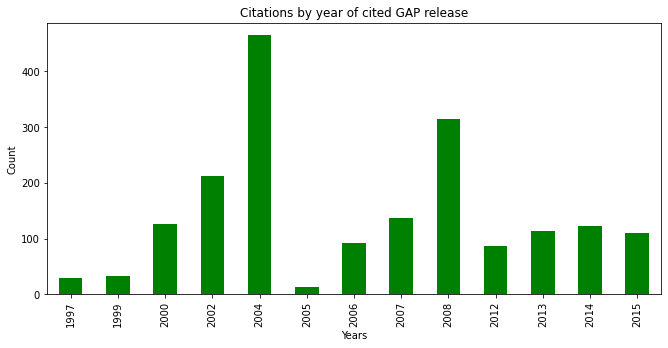

In [41]:
data.loc[sorted(data.index.intersection(range(1997, 2016)))].plot(kind="bar", 
                figsize=(11, 5), title='Citations by year of cited GAP release', xlabel='Years', 
                ylabel='Count', color='green')

all_years = corpus_df.groupby(['year','ReleaseYear'])['Year'].count()
all_years

In [42]:
get_citation('MR2592492')

('The Gap Group, Gap - Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.',
 '4.4.10')

# Merging the two dataframes with the equivalent of SQL `join`

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]

The `MR` column in `corpus_df` dataframe has the letters "MR" preceeding each number, first we will remove these letters, the the MR number format is the same in both datasets.

In [43]:
corpus_df['MR'] = corpus_df['MR'].str.extract('(\d+)', expand=False)
corpus_df

,MR,Citation,Version,Website,ReleaseYear
0,4056124,"GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.",None,Yes,Unknown
1,3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.: ""Numerical Sgps"", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. A...",Package,Yes,Unknown
2,3942387,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes,2014
3,3354065,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes,2008
4,3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes,2015
...,...,...,...,...,...
3537,3988630,"M. Delgado, P. A. García-Sánchez and J. Morais. Numericalsgps: a ${\ssf gap}$ package on numerical semigroups, (http://www.gap-system.org/Packages/numeri...",Package,Yes,Unknown
3538,1801202,"L.H. Soicher, GRAPE: a system for computing with graphs and groups, in: L. Finkelstein and W.M. Kantor, eds., Groups and Computation, DIMACS Series in Di...",None,Yes,Unknown
3539,2558870,"L. Bartholdi, Functionally recursive groups, http://www.gap-systems.org/Manuals/pkg/fr/doc/manual.pdf.",None,Yes,Unknown
3540,2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality gap in binary quadratic programming, Available from: http://www.optimization-online.org/DB_FILE/2010/01/2512...",None,Yes,Unknown


In [98]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3542 entries, 0 to 3541
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MR           3542 non-null   object
 1   Citation     3542 non-null   object
 2   Version      3003 non-null   object
 3   Website      3542 non-null   object
 4   ReleaseYear  3542 non-null   object
dtypes: object(5)
memory usage: 69.2+ KB


In [99]:
bib_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MR                3159 non-null   object 
 1   Author            3367 non-null   object 
 2   Journal           3047 non-null   object 
 3   Year              3363 non-null   float64
 4   Publication Type  3367 non-null   object 
dtypes: float64(1), object(4)
memory usage: 79.0+ KB


* With the following code we are joining the two datasets on the `MR` column and using `corpus_df` as a base. The resulting dataset will have as many lines as `corpus_df` but all columns from `bib_df` will be added, hence we will have much more information to work with.

In [46]:
merged_df = pd.merge(bib_df, corpus_df, on='MR', how='right', indicator=True)

We use Regex to further purify the `Citation` column, removing some remaining special characters.

In [100]:
merged_df['Citation'] = merged_df['Citation'].str.replace(r'[\\\$\{\}\^]', '')
merged_df['Citation'] = merged_df['Citation'].str.replace(r'(ssf)', '')

<ipython-input-100-e299e3edd306>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['Citation'] = merged_df['Citation'].str.replace(r'[\\\$\{\}\^]', '')
<ipython-input-100-e299e3edd306>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['Citation'] = merged_df['Citation'].str.replace(r'(ssf)', '')


In [101]:
for index, row in merged_df.iterrows():
    print(row['MR'], row['Citation'])

4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
3646312 The GAP Group, GAP–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
2287843 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).
2175389 The GAP Group, GAP-Groups, Algorithms, and programming, Versio

2408485 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.6; Aachen, St Andrews, 2005, available at http://www.gap-system.org/.
2408485 L. H. Soicher, The DESIGN package for GAP, available at http://designtheory.org/software/gap_design/.
2684077 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4; 2004, http://www.gap-system.org.
2684077 L.H. Soicher, The GRAPE package for GAP, Version 4.3, 2006, http://www.maths.qmul.ac.uk/simleonard/grape/.
2956331 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.4, 2004, http://www.gap-system.org.
3010114 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004. http://www.gap-system.org.
3337174 J. Bamberg et al., FinInG—a finite geometry package for GAP, Version 1.0, 2011; cage.ugent.be/fining/.
3337174 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.6.2, 2013, www.gap-system.org.
3337174 A. Hanaki, Elementary functions for association schemes on GAP, math.shinsh

4063325 The GAP Group, GAP-Groups, Algorithms and Programming, v.4.10. Available online (https://www.gap-system.org/).
2355031 The GAP group, GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org, 2005.
1709146 M. Schönert et. al., GAP – Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
1963688 M. Schönert, et al., GAP—Groups, Algorithms, and Programming, 5th ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995.
2729384 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
3250446 The GAP Group, GAP-Groups, Algorithms, and Programming, version 4.4.12, http://www.gap-system.org, 2012.
3545503 The GAP Group: GAP—Groups, Algorithms, and Programming, version 4.4.9 (2006). http://www.gapsystem.org
3849678 The GAP Group, GAP-Groups, Algorithms, and Programming, version 

1443190 F. Celler, M. F. Newman, W. Nickel and A. C. Niemeyer, An algorithm for computing quotients of prime-power order for finitely presented groups and its implementation in GAP, Research Report 127, Australian National University, Canberra, 1993.
1443190 George Havas, M.F. Newman and E.A. O'Brien, ANU p-Quotient Program (Version 1.2), written in C. available from maths.anu.edu.au by anonymous ftp in the directory pub/PQ, as a share library with GAP 3.4 and as part of Magma, 1995.
1443190 Martin Schönert et al., GAP - Groups, Algorithms, and Programming, Release 3.4, Lehrstuhl D für Mathematik, Rheinisch-Westfälische Technische Hochschule, Aachen, Germany, 1995.
1482983 G. Havas, M. F. Newman, and E. A. O'Brien, ANU p-Quotient program (version 1.4), written in C, available from maths.anu.edu.au by anonymous ftp in the directory pub PQ, as a share library with GAP and as part of Magma (1997).
1482983 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," Release 3.4, Lehrstuh

2220417 The GAP Group. Gap–Groups, Algorithms, and Programming, Version 4.4 (2004). http://www.gap-system.org.
1816718 The GAP Group, "GAP-Groups, Algorithms, and Programming," Version 4.2, Aachen/St. Andrews, 1999, http://www-gap.dcs.st-and.ac.uk/sim gap.
2228206 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
2955219 The Gap Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
3828795 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, http://www.gap-system.org, 2016.
2195590 V. Dabbaghian-Abdoly, REPSN - A Package for Constructing Representations of Finite Groups. GAP package. http://www.gap_system.org/Packages/repsn.html 2004. 
MR2168613
2195590 The GAP Group, GAP-Groups, Algorithms, Programming-A System for Computation Discrete Algebra. Version 4.3, 2002, http://www.gap-system.org.
2299793 V. Dabbaghian-Abdoly, RPSEN - A Package for Constructing Representations of

4134829 The GAP Group, GAP – Groups, Algorithms, and Programming, http://www.gapsystem.org
4134829 M. Neunhöffer, Á. Seress, et al., "The GAP Package recog." A Collection of Group Recognition Methods, http://gap-packages.github.io/recog/
3294861 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.4.12; 2008. (http://www.gap-system.org)
2721798 The GAP Group, GAP-Groups, Algorithms and Programming Version 4.3 Aachen, St Andrews. (2002). (http://www.gap-system.org).
2128082 The GAP Group (2002) GAP: Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org
2434275 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4; 2004, http://www.gap-system.org.
2610979 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.9 (2006), available at http://www.gap-system.org.
4048472 B. Eick, M. Horn and W. Nickel, Polycyclic – Computation with polycyclic groups, Version 2.11, 2013 – A GAP 4 package, in: The Gap Group, GAP—Groups, Algorithms, a

2093230 GAP, 1997. GAP–Groups, Algorithms, and Programming. The GAP Team. University of St. Andrews, Scotland. Available from http://www-gap.dcs.st-and.ac.uk/simgap/.
2228655 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
1844703 B. Eick and W. Nickel, "Polycyclic," A GAP [15] software package, 2000.
1844703 E. H. Lo, "PCQA," A GAP [15] software share package, 1995.
1844703 The GAP Group, "GAP-Groups, Algorithms, and Programming," Version 4.2, Aachen, St. Andrews, 2000 [http://www-gap.dcs.st-and.ac.uk/simgap].
1972750 Karel Dekimpe and Bettina Eick, Aclib, 2000, A GAP share package, see [15].
1972750 Bettina Eick and Werner Nickel, Polycyclic, 2000, A GAP share package, see [15].
1972750 The GAP Group, GAP—Groups, Algorithms and Programming, www.gap-system.org, 2000.
1879377 Schönert, M. et al. (1995). GAP-Groups, Algorithms and Programming, 5romanth edn. Aachen, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochsch

2639308 Michel, J., 1997. Garside and braid monoids and groups. In: The GAP Manual. (Chapter 82). Available at http://www.math.jussieu.fr/simjmichel/htm/CHAP082.htm.
1480786 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, fourth ed., RWTH Aachen, Germany, 1994.
1769289 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," 4th ed., Lehrstuhl D für Mathematik, Aachen, Germany, 1994.
1685620 M. Schönert et al. - GAP - Groups, algorithms, and programming, Lehrstuhl D für Mathematik, RWTH Aachen (1994), http://www.math.rwth-aachen.de/LDFM
1425324 M. Schönert et al., `GAP - groups, algorithms, and programming', 4th edn, Lehrstuhl D für Mathematik, RWTH Aachen, Germany, 1994.
1195429 M. Schönert (Editor), GAP 3.0 manual, Lehrstuhl D für Mathematik, RWTH Aachen, 1991.
3037782 J. Michel, Development version of the GAP-part of CHEVIE. Webpage and GAP3 package; see http://people.math.jussieu.fr/~jmichel/chevie/chevie.html
3378861 M. Geck, PyCox 

2247657 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4 (2004). (http://www.gap-system.org)
2975410 The GAP Group, GAP–Groups, Algorithms, and Programming, version 4.4.9, 2006, http://www.gap-system.org.
1823074 Schönert et al., M. (1994). GAP—Groups, Algorithms and Programming. Lehrstuhl D für Mathematik, RWTH Aachen.
2566544 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
3339804 The GAP Group, GAP – groups, algorithms, and programming, Version 4.7.4 (2014), http://www.gap-system.org.
3724268 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.4, 2016 (http://www.gap-system.org).
3177516 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008. (http://www.gap-system.org)
2354047 I. M. Araújo, et. al., GAP Reference Manual, The GAP Group, http://www.gap-system.org.
2429460 I. M. Araújo, et. al., GAP Reference Manual, The GAP Group, http://www.gap-system.org.
2429460 J. C

3240828 L. Maas, F. Noeske, GAP-package moc—modular characters, in preparation, http://www.math.rwth-aachen.de/simFelix.Noeske.
3240828 R. Wilson, R. Parker, S. Nickerson, J. Bray, T. Breuer, GAP-package AtlasRep—A GAP interface to the Atlas of group representations, Version 1.5.0, http://www.gap-system.org/Packages/atlasrep.html, 2011.
3518397 T. Breuer, The GAP Character Table Library, Version 1.2.2, GAP package, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
3698689 The GAP Group, GAP — Groups, algorithms, and programming, Version 4.8.4, 2016, http://www.gap-system.org.
4213626 The GAP Group, GAP – groups, algorithms, and programming, version 4.11.0, https://www.gap-system.org, 2020.
2338244 The GAP Group. GAP-Groups, Algorithms, and Programming, Version 4.4, Aachen-St. Andrews, 2004 (http://www.gap-system.org).
2437897 GAP, Groups, Algorithms and Programming, a System for Computational Discrete Algebra, Release 4.3, 06 May 2002, URL: http://www.gap-system.org.
3403498 The G

3442961 GAP—Groups, Algorithms, and Programming, Version 4.4.10, The GAP Group, http://www.gap-system.org, 2007.
2726573 GAP system, http://www.gap-system.org.
3343221 J. Michel, The Chevie GAP3 package, webusers.imj-prg.fr/~jean.michel/chevie, 1997.
3447647 Jean Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015), 308–336, DOI 10.1016/j.jalgebra.2015.03.031. MR3343221 
MR3343221
1800751 M. Schönert et al., "GAP 3.4 Manual (Groups, Algorithms and Programming)," RWTH Aachen, Aachen, Germany, 1994.
1614206 M. Schönert and others, "GAP-Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, RWTH, Aachen, Germany, 1992.
1825823 M. Schönert et al. GAP 3.4 Manual (Groups, Algorithms and Programming). RWTH Aachen, 1994.
2031331 M. Schönert et al., GAP 3.4 Manual (Groups, Algorithms and Programming), RWTH Aachen, Aachen, Germany, 1994.
1921730 M. Schönert et al., GAP 3.4 Manual (Groups, Algorithms and Programming). RWTH Aachen 1994.
1997749 M. Schöner

4204560 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.9.1 (2020). (https://www.gap-system.org/Contacts/cite.html)
2259067 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
1838096 M. Schönert et al., GAP - Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH Aachen, fifth edition, 1995, (http://www.gap.dcs.stand.ac.uk/gap).
2336398 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4; 2004, (http://www.gap-system.org)
3272374 GAP-Group, GAP—Groups, Algorithms, and Programming, version 4.7.2, http://www.gap-system.org, 2013.
3272374 M. Neunhöeffer, GAP package recog, version 1.2, http://www-groups.mcs.st-and.ac.uk/simneunhoef/Computer/Software/ Gap/recog.html, 28 May 2012.
2375459 The GAP Group (2004) GAP–Groups, Algorithms, and Programming, Version 4.4; (http://www.gapsystem.org)
3609385 The GAP Group, GAP — Groups, algorithms, and programming, Version 4.5.4, 2012, http://www.gap-sy

4163146 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.9.1, http://www.gap-system.org, 2018.
3787813 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.12, 2008, (http://www.gap-system.org).
3197181 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
2181415 Lehrstuhl D für Mathematik, RWTH Aachen, GAP, Computer Program available from http://www-gap.dcs.st-and.ac.uk/gap.
1877726 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.1, Aachen, St. Andrews, 1999, http://www-gap.dcs.st-and.ac.uk/simgap.
1765312 M. Schönert et al., GAP 3.4 Manual (Groups, Algorithms, and Programming), RWTH Aachen, 1994.
3981699 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.7.9, 2015. Available at: http://www.gap-system.org.
2287698 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.2; Aachen, St. Andrews, 2000. http://www-gap.dcs.st-and.ac.uk/simgap
2287698 The GAP 

##### We remove the unnecessary `merge` column and add a `lenght` column to reflect the character lenght of each citation.

In [47]:
merged_df = merged_df.drop(['_merge'], axis=1)
merged_df['Lentght'] = merged_df['Citation'].apply(len)
merged_df

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,ReleaseYear,Lentght
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020.0,article,"GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.",None,Yes,Unknown,104
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A Mat. RACSAM,2019.0,article,"Delgado, M., García-Sánchez, P.A., Morais, J.: ""Numerical Sgps"", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. A...",Package,Yes,Unknown,183
2,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A Mat. RACSAM,2019.0,article,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes,2014,125
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015.0,article,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes,2008,87
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and Niemeyer, A. C.",J. Pure Appl. Algebra,2017.0,article,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes,2015,111
...,...,...,...,...,...,...,...,...,...,...
3538,3988630,"Rosales, J. C. and Branco, M. B.",Proc. Roy. Soc. Edinburgh Sect. A,2019.0,article,"M. Delgado, P. A. García-Sánchez and J. Morais. Numericalsgps: a ${\ssf gap}$ package on numerical semigroups, (http://www.gap-system.org/Packages/numeri...",Package,Yes,Unknown,167
3539,1801202,"Shaw, R.",Des. Codes Cryptogr.,2000.0,incollection,"L.H. Soicher, GRAPE: a system for computing with graphs and groups, in: L. Finkelstein and W.M. Kantor, eds., Groups and Computation, DIMACS Series in Di...",None,Yes,Unknown,327
3540,2558870,"Sidki, S. N.",J. Algebra,2009.0,article,"L. Bartholdi, Functionally recursive groups, http://www.gap-systems.org/Manuals/pkg/fr/doc/manual.pdf.",None,Yes,Unknown,102
3541,2824780,"Tian, Y. and Lu, C.",J. Ind. Manag. Optim.,2011.0,article,"X. Sun, C. Liu, D. Li and J. Gao, On duality gap in binary quadratic programming, Available from: http://www.optimization-online.org/DB_FILE/2010/01/2512...",None,Yes,Unknown,158


### Now we split the extended dataset in two dataframes for further analysis

### Pure GAP citations  

In [48]:
gap_df = merged_df[merged_df['Version'] != 'Package']
gap_df = gap_df.dropna()
gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2219 entries, 2 to 3532
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MR                2219 non-null   object 
 1   Author            2219 non-null   object 
 2   Journal           2219 non-null   object 
 3   Year              2219 non-null   float64
 4   Publication Type  2219 non-null   object 
 5   Citation          2219 non-null   object 
 6   Version           2219 non-null   object 
 7   Website           2219 non-null   object 
 8   ReleaseYear       2219 non-null   object 
 9   Lentght           2219 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 121.4+ KB


### GAP Packages Citations

In [49]:
pac_df = merged_df[merged_df['Version'] == 'Package']
pac_df = pac_df.dropna()
pac_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 1 to 3538
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MR                694 non-null    object 
 1   Author            694 non-null    object 
 2   Journal           694 non-null    object 
 3   Year              694 non-null    float64
 4   Publication Type  694 non-null    object 
 5   Citation          694 non-null    object 
 6   Version           694 non-null    object 
 7   Website           694 non-null    object 
 8   ReleaseYear       694 non-null    object 
 9   Lentght           694 non-null    int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 38.0+ KB


In [51]:
gap_df[gap_df['Lentght'] < 75]

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,ReleaseYear,Lentght
253,2176489,"Ash, A. and Pollack, D. and Sinnott, W.",J. Number Theory,2005.0,article,"GAP4, Version: 4.3fix4. Available: http://www.gap-system.org.",4.3,Yes,2002,61
355,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013.0,article,"The GAP Group, GAP–Groups, Algorithms, Programming, v. 4.5.7, 2012",4.5.7,No,2012,66
730,2301234,"Burness, T. C.",J. Algebra,2007.0,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,2004,74
731,2344583,"Burness, T. C.",J. Algebra,2007.0,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,2004,74
732,2344583,"Burness, T. C.",J. Algebra,2007.0,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,2004,74
733,2344584,"Burness, T. C.",J. Algebra,2007.0,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,2004,74
734,2344584,"Burness, T. C.",J. Algebra,2007.0,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,2004,74
743,3219555,"Burness, T. C. and Guralnick, R. M. and Saxl, J.",Israel J. Math.,2014.0,article,"The GAP Group, GAP–Groups, Algorithms and Programming, Version 4.4, 2004.",4.4,No,2004,73
900,2242478,"Chesnokov, A. A. and Haemers, W. H.",Linear Algebra Appl.,2006.0,article,"GAP—Groups, Algorithms and Programming, Version 4.3, 2002.",4.3,No,2002,58
965,1909574,"Cousineau, G.",Theoret. Comput. Sci.,2002.0,incollection,"The GAP Group, GAP: Groups, Algorithms and Programming, Version 4.2, 2000.",4.2,No,2000,74


y = gap_df['Year']
ry = gap_df.to_numeric('ReleaseYear')
tail = y - ry
#gap_df.insert(loc=2, column='Tail', value=' ')
gap_df['Tail'] = [gap_df['Year']]
gap_df

In [102]:
get_c('3092787')

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,ReleaseYear,Lentght
354,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013.0,article,"Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with permutability, v.0.03, available at http://personales.upv...",Package,Yes,Unknown,188
355,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013.0,article,"The GAP Group, GAP–Groups, Algorithms, Programming, v. 4.5.7, 2012",4.5.7,No,2012,66


In [59]:
merged_df.loc[354]['Citation']

'Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with permutability, v.0.03, available at http://personales.upv.es/$\\sim$resteban/gap/permut-0.03/'

# Visualisations

### Website

<AxesSubplot:title={'center':'Website statistics on the whole data'}, ylabel='Provided?'>

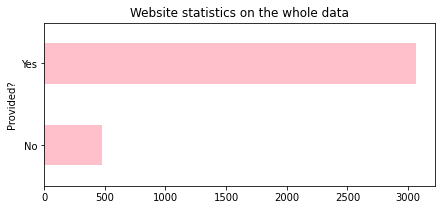

In [60]:
web_chart = corpus_df['Website'].value_counts()
web_chart = web_chart.sort_values(ascending=True)
web_chart.plot(kind="barh", figsize=(7, 3), title='Website statistics on the whole data', 
                xlabel='Provided?', ylabel='Count', color='pink')

<AxesSubplot:title={'center':'Website statistics on the Pure GAP data only'}, ylabel='Provided?'>

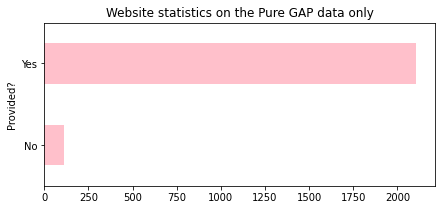

In [61]:
web_gap = gap_df['Website'].value_counts()
web_gap = web_gap.sort_values(ascending=True)
web_gap.plot(kind="barh", figsize=(7, 3), title='Website statistics on the Pure GAP data only', 
                xlabel='Provided?', ylabel='Count', color='pink')

<AxesSubplot:title={'center':'Website statistics on the Package citation data'}, ylabel='Provided?'>

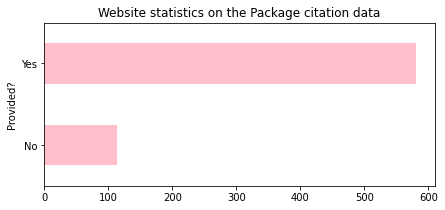

In [62]:
web_pac = pac_df['Website'].value_counts()
web_pac = web_pac.sort_values(ascending=True)
web_pac.plot(kind="barh", figsize=(7, 3), title='Website statistics on the Package citation data', 
                xlabel='Provided?', ylabel='Count', color='pink')

In [63]:
site_year = merged_df.groupby('Website').count()
site_year

,MR,Author,Journal,Year,Publication Type,Citation,Version,ReleaseYear,Lentght
Website,,,,,,,,,
No,475,475,455,475,475,475,244,475,475
Yes,3068,3061,2985,3056,3061,3068,2759,3068,3068


from pandas.plotting import parallel_coordinates

parallel_coordinates(all_years, "Year")

### Lenght
* Most citations are around 110 characters long.

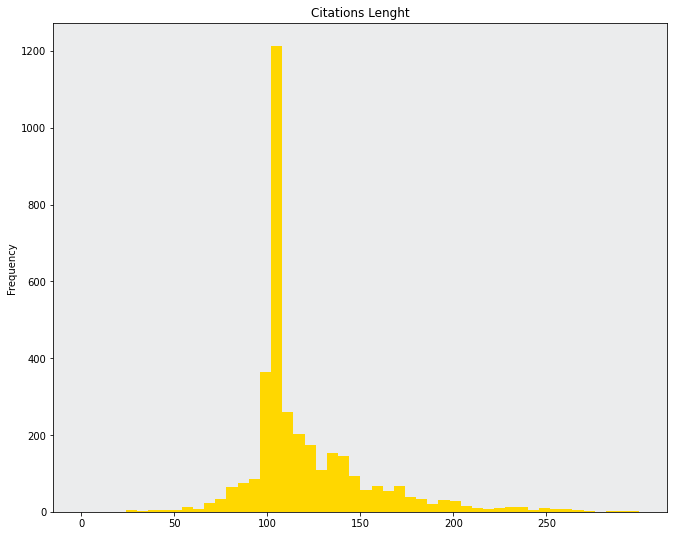

In [65]:
merged_df['Lentght'] = merged_df['Citation'].apply(len)
cit_len = merged_df['Lentght'].plot(kind='hist', bins=50, figsize=(11,9), stacked=True, 
                         xticks = range(0, 300, 50), 
                         range=(0, 300), 
                         color='gold', 
                         title='Citations Lenght', 
                         xlabel="lenght")
cit_len.set_facecolor('#ebeced')


In [ ]:
merged_df

year_df = merged_df.sort_values(by='Year', ascending=False)
year_df.dropna()
num = year_df['Journal'].count()
year_df.plot(x='Year', y=num, kind='barh')


### Version

<AxesSubplot:title={'center':'Top 50 most cited GAP versions'}, xlabel='Version', ylabel='Count'>

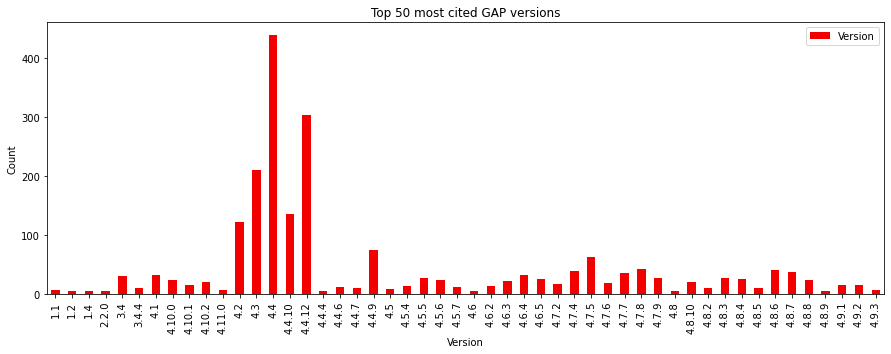

In [67]:
ver = gap_df['Version'].value_counts()
ver = ver.head(50)
ver = ver.to_frame()
ver = ver.sort_index() # sort chrono. compare version numbers
ver = ver.dropna()
ver.plot(kind="bar", figsize=(15, 5), title='Top 50 most cited GAP versions', xlabel='Version', 
                ylabel='Count', color='#f20000')

* We can see that the most popular GAP versions cited are subversions of GAP 4, between 4.2 and 4.4

In [68]:
gap_df['Version'].value_counts()

4.4          439
4.4.12       303
4.3          211
4.4.10       135
4.2          122
            ... 
0911.5589      1
4.5.3          1
4.6.12         1
10.1109        1
1.3.3          1
Name: Version, Length: 97, dtype: int64

### Authors

* Top 20 authors citing GAP and its packages in their work.

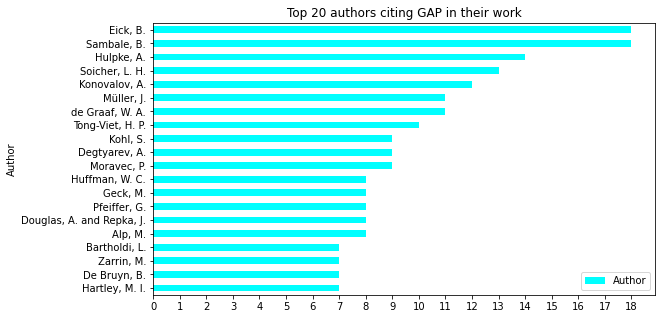

In [81]:
authors = bib_df['Author'].value_counts()
top = authors.head(20)
top = top.sort_values(ascending=True)
top = top.to_frame()
chart = top.plot(kind="barh",
                 figsize=(9,5), title='Top 20 authors citing GAP in their work', 
                 xlabel='Author', 
                 ylabel='Count', color='cyan', 
                  xticks=range(0, 19, 1))
# how do we treat joint papers ?

* Top 20 authors citing GAP Packages

In [73]:
author = pac_df['Author'].value_counts()
top20 = author.head(20)
top20 = top20.sort_values(ascending=False)
top20 = top20.to_frame()
top20

#chart = top20.plot(kind="bar",
#                 figsize=(9,5), title='Top 20 authors citing GAP Packages', 
#                 xlabel='Author', 
#                 ylabel='Count', color='brown', 
#                  xticks=range(0, 19, 1))

,Author
"Koshitani, S. and Müller, J. and Noeske, F.",10
"Bächle, A. and Margolis, L.",10
"Soicher, L. H.",8
"Eick, B.",7
"Kohl, S.",6
"Eick, B. and Horn, M.",6
"Douglas, A. and Repka, J.",6
"de Graaf, W. A.",5
"Fernandes, V. H.",5
"Assmann, B. and Eick, B.",5


* Accuracy + site, ver, year
* Countries + to be provided
* GET function + simplicity is key

### Year

##### Barchart dislaying number of GAP citations per year.

* GAP citation counts for each year, sorted chronologically.

In [ ]:
year_chrono = merged_df['Year'].value_counts()
chrono_df = year_chrono.to_frame()
chrono = chrono_df.sort_index()
chrono.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Year', 
                ylabel='Count', color='purple')

Top 20 journals citing GAP.

In [74]:
top_journals = gap_df['Journal'].value_counts()
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,Journal
0,J. Algebra,307
1,Comm. Algebra,146
2,J. Algebra Appl.,76
3,Discrete Math.,74
4,J. Symbolic Comput.,57
5,J. Group Theory,54
6,J. Pure Appl. Algebra,51
7,Des. Codes Cryptogr.,46
8,Internat. J. Algebra Comput.,45
9,LMS J. Comput. Math.,42


Only for alternative, useful for copy/paste plain text - quick to load.
Try to allign on the left - journals.

In [75]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         307         |
|        Comm. Algebra         |         146         |
|       J. Algebra Appl.       |         76          |
|        Discrete Math.        |         74          |
|     J. Symbolic Comput.      |         57          |
|       J. Group Theory        |         54          |
|    J. Pure Appl. Algebra     |         51          |
|     Des. Codes Cryptogr.     |         46          |
| Internat. J. Algebra Comput. |         45          |
|     LMS J. Comput. Math.     |         42          |
|       Israel J. Math.        |         33          |
|     Arch. Math. (Basel)      |         33          |
|       J. Combin. Des.        |         28          |
|     European J. Combin.      |         28          |
|         Math. Comp.          |         27          |
|       Al

##### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

In [76]:
types_pub = pd.DataFrame(bib_df['Publication Type'].value_counts())
types_pub.columns = ['GAP Citations Count']
types_pub.index.names = ['Publication Type']
types_pub

,GAP Citations Count
Publication Type,
article,2976
incollection,204
inproceedings,54
phdthesis,47
mastersthesis,46
book,31
misc,5
techreport,2
manual,1


# Interactive

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

interact(f, x=['apples','oranges']);

Versions / year
top authors / year
data per year